### <span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#191970;">Project 7 - Time Series Forecasting on Sparkling Wine Sales - Part 1

#### <span style="font-family: Arial; font-weight:regular;font-size:1.2em;color:#708090;">Project by - Madhu Narayanan  

#### <span style="font-family: Arial; font-weight:regular;font-size:1.2em;color:#708090;">Batch - G2D - July 2020

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#008080;"> Problem Statement

As an analyst in the ABC Estate Wines, you are tasked to analyse and forecast 'Sparkling Wine Sales in the 20th century.

Data set for the Problem: <u>Sparkling.csv</u>

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#1E90FF;">Import important libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import sklearn
import statsmodels
import datetime
from pylab import rcParams

from statsmodels.tsa.seasonal import   seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn import metrics
from sklearn.metrics import  mean_squared_error
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
## This is to display multiple data frames from one cell
from IPython.display import display
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#4B0082;">1. Read the data as an appropriate Time Series data and plot the data.

In [2]:
df = pd.read_csv('Sparkling.csv')
df.head(100)

YearMonth  Sparkling
0    1980-01       1686
1    1980-02       1591
2    1980-03       2304
3    1980-04       1712
4    1980-05       1471
..       ...        ...
95   1987-12       7242
96   1988-01       1853
97   1988-02       1779
98   1988-03       2108
99   1988-04       2336

[100 rows x 2 columns]

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#1E90FF;">Creating the Time Stamps and adding to the data frame to make it a Time Series Data

In [3]:
date = pd.date_range(start='1/31/1980', end='07/31/1995', freq='M')
date

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '1994-10-31', '1994-11-30', '1994-12-31', '1995-01-31',
               '1995-02-28', '1995-03-31', '1995-04-30', '1995-05-31',
               '1995-06-30', '1995-07-31'],
              dtype='datetime64[ns]', length=187, freq='M')

In [4]:
# Adding the time stamp to the data frame
df['Time_Stamp'] = pd.DataFrame(date)
df.head()

YearMonth  Sparkling Time_Stamp
0   1980-01       1686 1980-01-31
1   1980-02       1591 1980-02-29
2   1980-03       2304 1980-03-31
3   1980-04       1712 1980-04-30
4   1980-05       1471 1980-05-31

In [5]:
df.set_index('Time_Stamp',inplace=True)
df.head()

YearMonth  Sparkling
Time_Stamp                     
1980-01-31   1980-01       1686
1980-02-29   1980-02       1591
1980-03-31   1980-03       2304
1980-04-30   1980-04       1712
1980-05-31   1980-05       1471

In [6]:
df.drop('YearMonth',axis=1,inplace=True)

In [7]:
df

Sparkling
Time_Stamp           
1980-01-31       1686
1980-02-29       1591
1980-03-31       2304
1980-04-30       1712
1980-05-31       1471
...               ...
1995-03-31       1897
1995-04-30       1862
1995-05-31       1670
1995-06-30       1688
1995-07-31       2031

[187 rows x 1 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-31 to 1995-07-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sparkling  187 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


In [9]:
df.isnull().sum()

Sparkling    0
dtype: int64

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#4B0082;">2. Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.

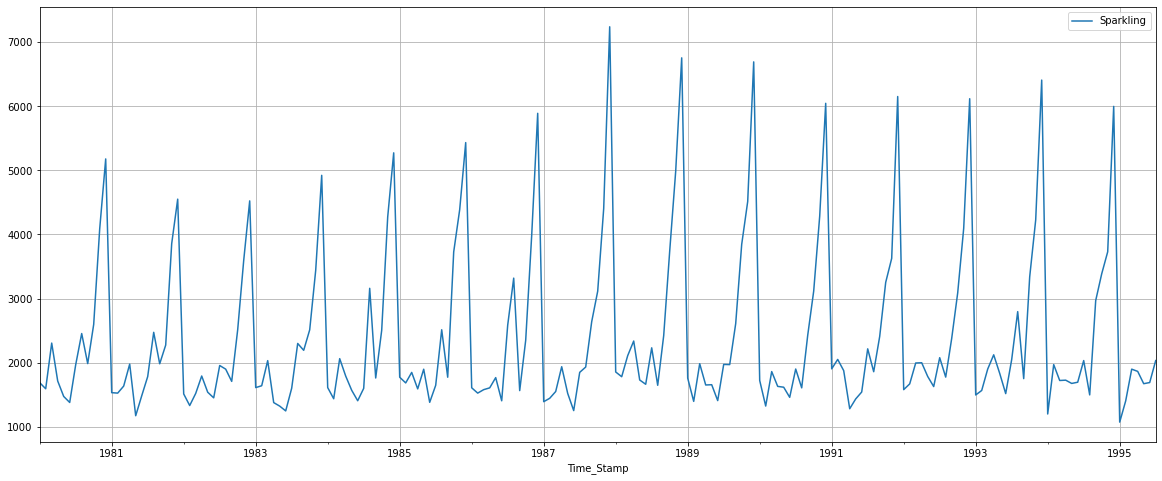

In [10]:
rcParams['figure.figsize'] = 20,8
df.plot()
plt.grid()

In [11]:
df.describe().T

count         mean         std     min     25%     50%     75%  \
Sparkling  187.0  2402.417112  1295.11154  1070.0  1605.0  1874.0  2549.0   

              max  
Sparkling  7242.0

The basic measures of descriptive statistics tell us how the 'Wine Sales' have varied across years. But remember, for this measure of descriptive statistics we have averaged over the whole data without taking the time component into account.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#1E90FF;">Plotting a boxplot to understand the spread of 'Sparkling Wine Sales' across different years and within different months across years.

In [12]:
monthly_sales_across_years = pd.pivot_table(df, values = 'Sparkling', columns = df.index.month, index = df.index.year)
monthly_sales_across_years

Time_Stamp      1       2       3       4       5       6       7       8   \
Time_Stamp                                                                   
1980        1686.0  1591.0  2304.0  1712.0  1471.0  1377.0  1966.0  2453.0   
1981        1530.0  1523.0  1633.0  1976.0  1170.0  1480.0  1781.0  2472.0   
1982        1510.0  1329.0  1518.0  1790.0  1537.0  1449.0  1954.0  1897.0   
1983        1609.0  1638.0  2030.0  1375.0  1320.0  1245.0  1600.0  2298.0   
1984        1609.0  1435.0  2061.0  1789.0  1567.0  1404.0  1597.0  3159.0   
1985        1771.0  1682.0  1846.0  1589.0  1896.0  1379.0  1645.0  2512.0   
1986        1606.0  1523.0  1577.0  1605.0  1765.0  1403.0  2584.0  3318.0   
1987        1389.0  1442.0  1548.0  1935.0  1518.0  1250.0  1847.0  1930.0   
1988        1853.0  1779.0  2108.0  2336.0  1728.0  1661.0  2230.0  1645.0   
1989        1757.0  1394.0  1982.0  1650.0  1654.0  1406.0  1971.0  1968.0   
1990        1720.0  1321.0  1859.0  1628.0  1615.0  1457.0  1899.0  1605.0   
1991        1902.0  2049.0  1874.0  1279.0  1432.0  1540.0  2214.0  1857.0   
1992        1577.0  1667.0  1993.0  1997.0  1783.0  1625.0  2076.0  1773.0   
1993        1494.0  1564.0  1898.0  2121.0  1831.0  1515.0  2048.0  2795.0   
1994        1197.0  1968.0  1720.0  1725.0  1674.0  1693.0  2031.0  1495.0   
1995        1070.0  1402.0  1897.0  1862.0  1670.0  1688.0  2031.0     NaN   

Time_Stamp      9       10      11      12  
Time_Stamp                                  
1980        1984.0  2596.0  4087.0  5179.0  
1981        1981.0  2273.0  3857.0  4551.0  
1982        1706.0  2514.0  3593.0  4524.0  
1983        2191.0  2511.0  3440.0  4923.0  
1984        1759.0  2504.0  4273.0  5274.0  
1985        1771.0  3727.0  4388.0  5434.0  
1986        1562.0  2349.0  3987.0  5891.0  
1987        2638.0  3114.0  4405.0  7242.0  
1988        2421.0  3740.0  4988.0  6757.0  
1989        2608.0  3845.0  4514.0  6694.0  
1990        2424.0  3116.0  4286.0  6047.0  
1991        2408.0  3252.0  3627.0  6153.0  
1992        2377.0  3088.0  4096.0  6119.0  
1993        1749.0  3339.0  4227.0  6410.0  
1994        2968.0  3385.0  3729.0  5999.0  
1995           NaN     NaN     NaN     NaN

The data given for 'Sparkling Wine Sales' analysis is of 187 records(Months in this case) between the Time period of January 1980 to July 1995.

It is observed that there are no missing values in the dataset.

From the 'Time-Stamp' plot it is evident that there is seasonality (also let's check with Monthly Box-Plot). 

**Yearly Box-Plot**

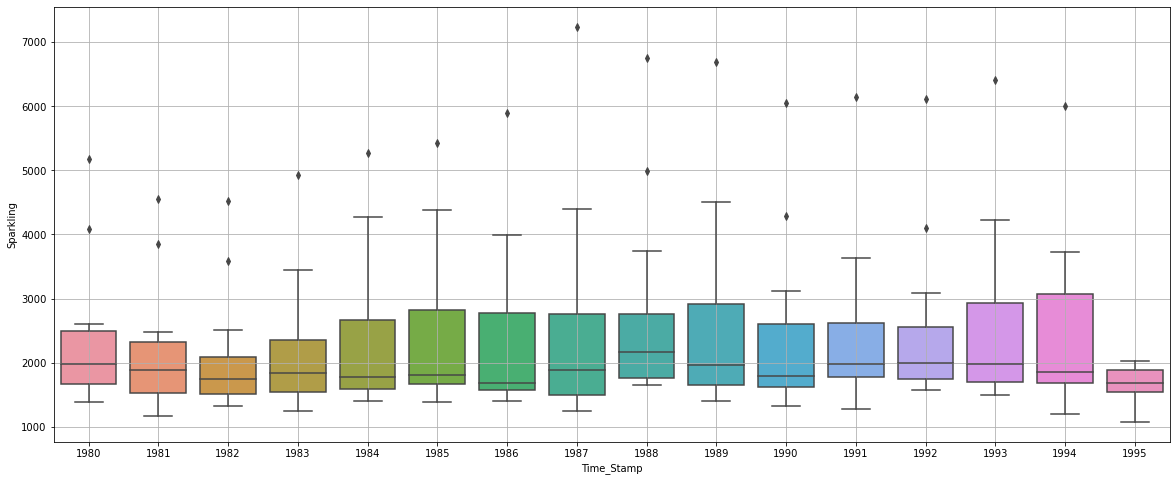

In [13]:
sns.boxplot(x = df.index.year,y = df['Sparkling'])
plt.grid();

**Monthly Box-Plot**

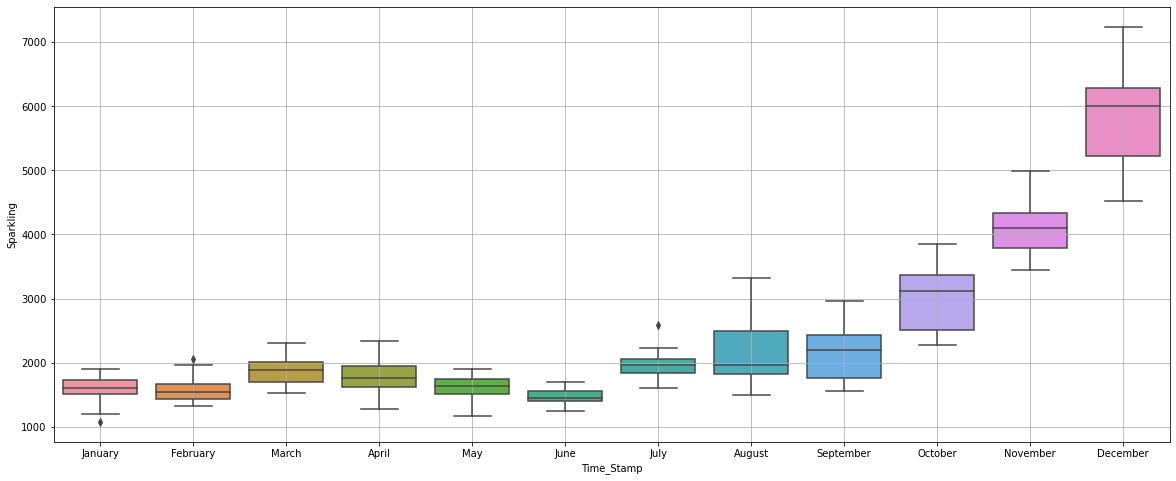

In [14]:
sns.boxplot(x = df.index.month_name(),y = df['Sparkling'])
plt.grid();

### Plotting the average 'Sparkiling Wine Sales' per month and the month on month percentage change of Sales.

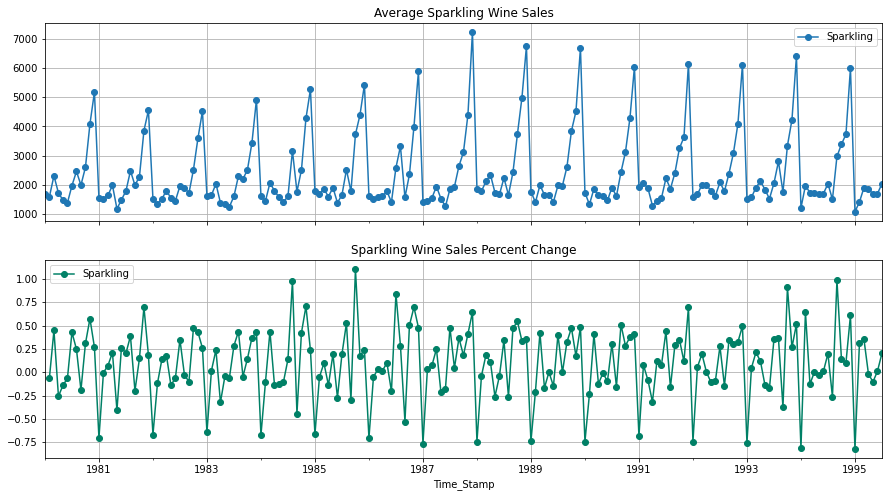

In [15]:
# group by date and get average Sparkling Wine Sales, and precent change
average    = df.groupby(df.index)["Sparkling"].mean()
pct_change = df.groupby(df.index)["Sparkling"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average Sparkling Wine Sales over time(year-month)
ax1 = average.plot(legend=True,ax=axis1,marker='o',title="Average Sparkling Wine Sales",grid=True)
ax1.set_xticks(range(len(average)))
ax1.set_xticklabels(average.index.tolist())
# plot precent change for Sparkling Wine Sales over time(year-month)
ax2 = pct_change.plot(legend=True,ax=axis2,marker='o',colormap="summer",title="Sparkling Wine Sales Percent Change",grid=True)

The sales has a fluctuating trend where it increased from 1983-1989 then there is a drop in Sales. 1993 tried to catch up with the peak trend of 1983-1989 but then dropped. 

Note: 1995 has only 7 months sales figure and not for entire 12 months of the year.

When we plot the Monthly Sales figures of 'Sparkling Wine Sales' across various years, there is a good seasonal trend emerging where the Sales peaks in December and has an increasing trend from August-December. Then the sales abruptly drops in January. This trend continues with minor variations between January-July.

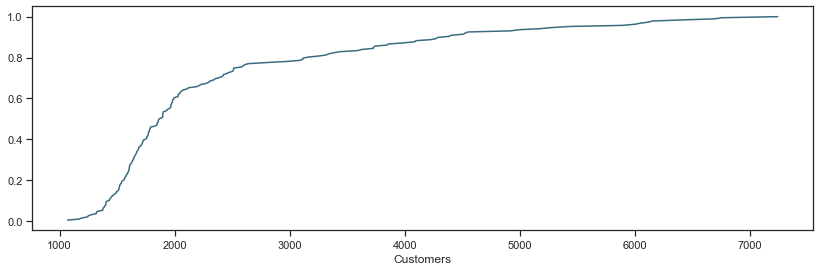

In [16]:
## Plot ECDF: Empirical Cumulative Distribution Function
#ECDF - Adds up the number of observations that are there for a certain value.
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (14,14))

  
plt.subplot(312)
cdf = ECDF(df['Sparkling'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Customers');

From the above Cumulative Distribution Function plot, it is seen that around 60-65% of Sales are around 2000 and below.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#1E90FF;">Decompose the Time Series and plot the different components.

Since the above Monthly Box-Plot and 'Time Series' plot, we got a glimpse of Sesonality apart from Trend on 'Sparkling Wine Sales'. To understand it better let's decompose the Time Series and plot different components of Trend, Seasonality & Residual(unexplained variance of Sales that is not explained in Trend and Seasonality)

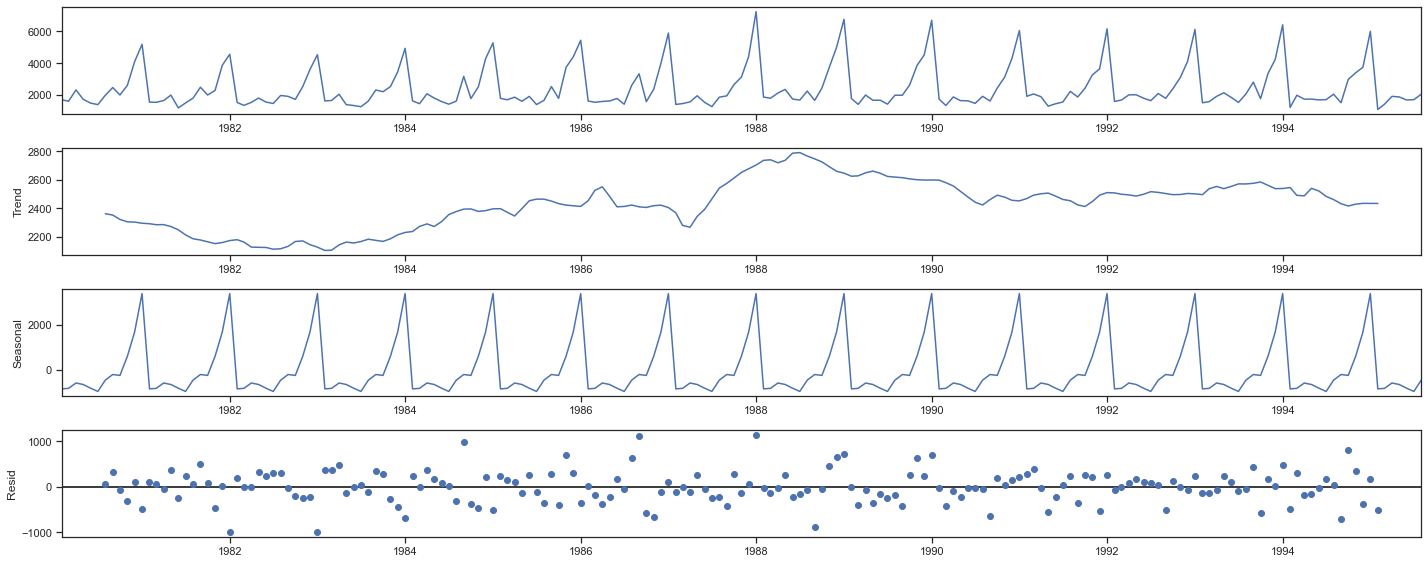

In [17]:
decomposition = seasonal_decompose(df,model='additive')
decomposition.plot();

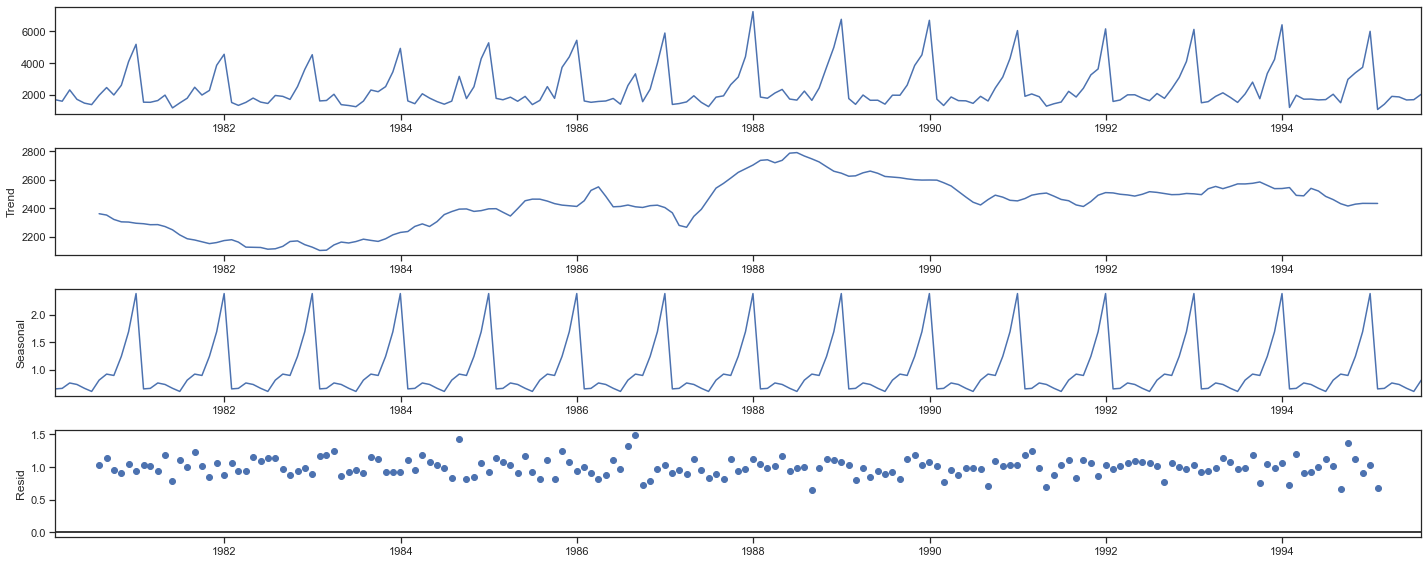

In [18]:
decomposition = seasonal_decompose(df,model='multiplicative')
decomposition.plot();

**From the above graph of decomposition the following are the insights: (Consider only 'additive model'
as the trend is not 'multiplicative'**  

    1. The Trend dipped in 'Sparkling Wine Sales' from 1980-1982.  
    2. The Trend shows increased Sales from 1983 and dipped a little in second half of 1996 uptill somewhere
       around mid of 1997. Then the sales grew again and attained plateau from 2nd half of 1991 to July1995.  
    3. The Seasonality is uniform across years.  
    4. There is a considerable presence of residual (unexplained variance).  
    

In [19]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 Time_Stamp
1980-01-31            NaN
1980-02-29            NaN
1980-03-31            NaN
1980-04-30            NaN
1980-05-31            NaN
1980-06-30            NaN
1980-07-31    2360.666667
1980-08-31    2351.333333
1980-09-30    2320.541667
1980-10-31    2303.583333
1980-11-30    2302.041667
1980-12-31    2293.791667
Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
1980-01-31    0.649843
1980-02-29    0.659214
1980-03-31    0.757440
1980-04-30    0.730351
1980-05-31    0.660609
1980-06-30    0.603468
1980-07-31    0.809164
1980-08-31    0.918822
1980-09-30    0.894367
1980-10-31    1.241789
1980-11-30    1.690158
1980-12-31    2.384776
Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
1980-01-31         NaN
1980-02-29         NaN
1980-03-31         NaN
1980-04-30         NaN
1980-05-31         NaN
1980-06-30         NaN
1980-07-31    1.029230
1980-08-31    1.135407
1980-09-30    0.955954
1980-10-31    0.907513
1980-11-30    1.050423
1980-12-31    0.946770
Name: r

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#4B0082;">3. Split the data into training and test. The test data should start in 1991.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#1E90FF;">Split the data into train and test and plot the training and test data. 
(Train data is Sales<1991 & Test data is >=1991)

In [20]:
train = df[df.index<'1991'] 
test = df[df.index>='1991']

In [21]:
print(train.shape)
print(test.shape)

(132, 1)
(55, 1)


In [22]:
print('First few rows of Training Data','\n',train.head(),'\n')
print('Last few rows of Training Data','\n',train.tail(),'\n')
print('First few rows of Test Data','\n',test.head(),'\n')
print('Last few rows of Test Data','\n',test.tail(),'\n')

First few rows of Training Data 
             Sparkling
Time_Stamp           
1980-01-31       1686
1980-02-29       1591
1980-03-31       2304
1980-04-30       1712
1980-05-31       1471 

Last few rows of Training Data 
             Sparkling
Time_Stamp           
1990-08-31       1605
1990-09-30       2424
1990-10-31       3116
1990-11-30       4286
1990-12-31       6047 

First few rows of Test Data 
             Sparkling
Time_Stamp           
1991-01-31       1902
1991-02-28       2049
1991-03-31       1874
1991-04-30       1279
1991-05-31       1432 

Last few rows of Test Data 
             Sparkling
Time_Stamp           
1995-03-31       1897
1995-04-30       1862
1995-05-31       1670
1995-06-30       1688
1995-07-31       2031 



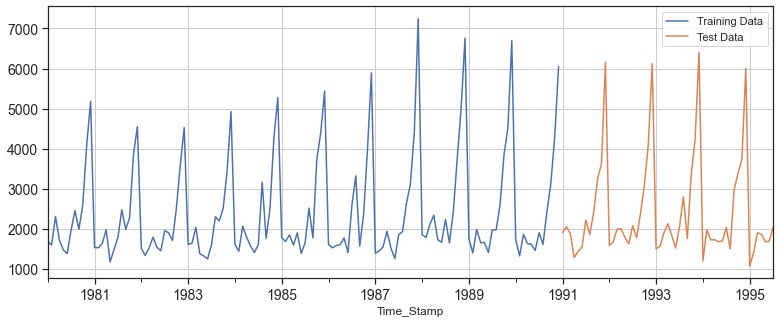

In [23]:
train['Sparkling'].plot(figsize=(13,5), fontsize=14)
test['Sparkling'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#4B0082;">4. Build various exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other models such as regression,naïve forecast models, simple average models etc. should also be built on the training data and check the performance on the test data using RMSE.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#1E90FF;">Building different models and comparing the accuracy metrics.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 1. Linear Regression

In [24]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+133 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
Test Time instance 
 [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


We see that we have successfully the generated the numerical time instance order for both the training and test set. Now we will add these values in the training and test set.

In [25]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [26]:
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

print('First few rows of Training Data','\n',LinearRegression_train.head(),'\n')
print('Last few rows of Training Data','\n',LinearRegression_train.tail(),'\n')
print('First few rows of Test Data','\n',LinearRegression_test.head(),'\n')
print('Last few rows of Test Data','\n',LinearRegression_test.tail(),'\n')

First few rows of Training Data 
             Sparkling  time
Time_Stamp                 
1980-01-31       1686     1
1980-02-29       1591     2
1980-03-31       2304     3
1980-04-30       1712     4
1980-05-31       1471     5 

Last few rows of Training Data 
             Sparkling  time
Time_Stamp                 
1990-08-31       1605   128
1990-09-30       2424   129
1990-10-31       3116   130
1990-11-30       4286   131
1990-12-31       6047   132 

First few rows of Test Data 
             Sparkling  time
Time_Stamp                 
1991-01-31       1902   133
1991-02-28       2049   134
1991-03-31       1874   135
1991-04-30       1279   136
1991-05-31       1432   137 

Last few rows of Test Data 
             Sparkling  time
Time_Stamp                 
1995-03-31       1897   183
1995-04-30       1862   184
1995-05-31       1670   185
1995-06-30       1688   186
1995-07-31       2031   187 



In [27]:
lr = LinearRegression()

In [28]:
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Sparkling'].values)

LinearRegression()

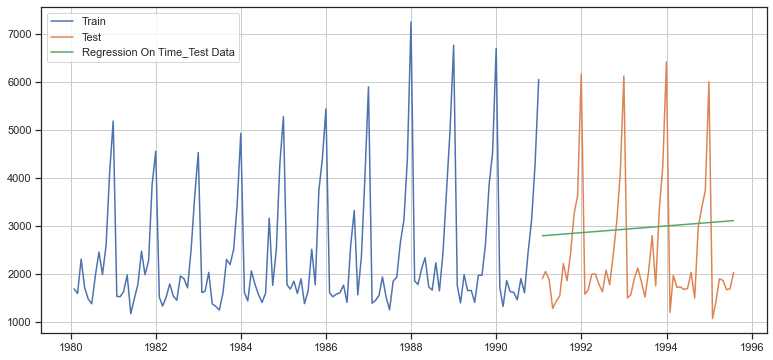

In [29]:
test_predictions_model1 = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime'] = test_predictions_model1

plt.figure(figsize=(13,6))
plt.plot( train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid();

**Model 1 - Linear Regression Evaluation (Defining the accuracy metrics)**

In [30]:
## Test Data - RMSE

rmse_model1_test = metrics.mean_squared_error(test['Sparkling'],test_predictions_model1,squared=False)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f" %(rmse_model1_test))

For RegressionOnTime forecast on the Test Data,  RMSE is 1389.135


In [31]:
resultsDf = pd.DataFrame({'Test RMSE': [rmse_model1_test]},index=['RegressionOnTime'])
resultsDf

Test RMSE
RegressionOnTime  1389.135175

#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 2: Naive Approach: $\hat{y}_{t+1} = y_t$

For this particular naive model, we say that the prediction for tomorrow is the same as today and the prediction for day after tomorrow is tomorrow and since the prediction of tomorrow is same as today,therefore the prediction for day after tomorrow is also today.

In [32]:
NaiveModel_train = train.copy()
NaiveModel_test = test.copy()

In [33]:
NaiveModel_test['naive'] = np.asarray(train['Sparkling'])[len(np.asarray(train['Sparkling']))-1]
NaiveModel_test['naive'].head()

Time_Stamp
1991-01-31    6047
1991-02-28    6047
1991-03-31    6047
1991-04-30    6047
1991-05-31    6047
Name: naive, dtype: int64

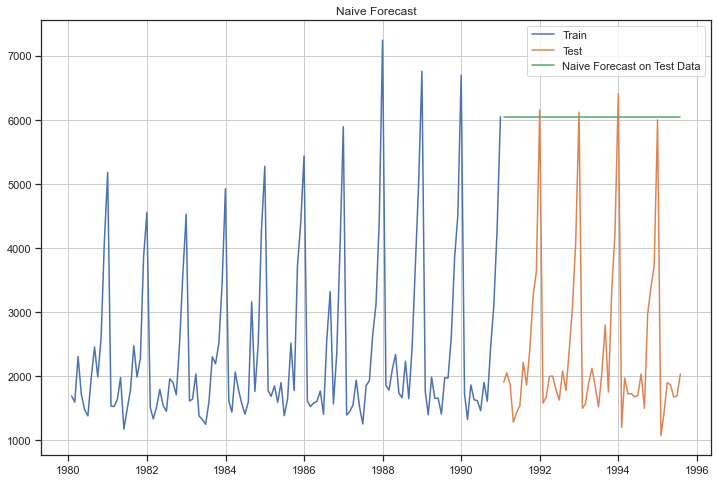

In [34]:
plt.figure(figsize=(12,8))
plt.plot(NaiveModel_train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid();

**Model 2 - Naive Approach Evaluation (Defining the accuracy metrics)**

In [35]:
## Test Data - RMSE

rmse_model2_test = metrics.mean_squared_error(test['Sparkling'],NaiveModel_test['naive'],squared=False)
print("For Naive Approach forecast on the Test Data,  RMSE is %3.3f" %(rmse_model2_test))

For Naive Approach forecast on the Test Data,  RMSE is 3864.279


In [36]:
resultsDf_2 = pd.DataFrame({'Test RMSE': [rmse_model2_test]},index=['NaiveModel'])

resultsDf = pd.concat([resultsDf, resultsDf_2])
resultsDf

Test RMSE
RegressionOnTime  1389.135175
NaiveModel        3864.279352

#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 3: Simple Average

**For this particular simple average method, we will forecast by using the average of the training values**

In [37]:
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

In [38]:
SimpleAverage_test['mean_forecast'] = train['Sparkling'].mean()
SimpleAverage_test.head()

Sparkling  mean_forecast
Time_Stamp                          
1991-01-31       1902    2403.780303
1991-02-28       2049    2403.780303
1991-03-31       1874    2403.780303
1991-04-30       1279    2403.780303
1991-05-31       1432    2403.780303

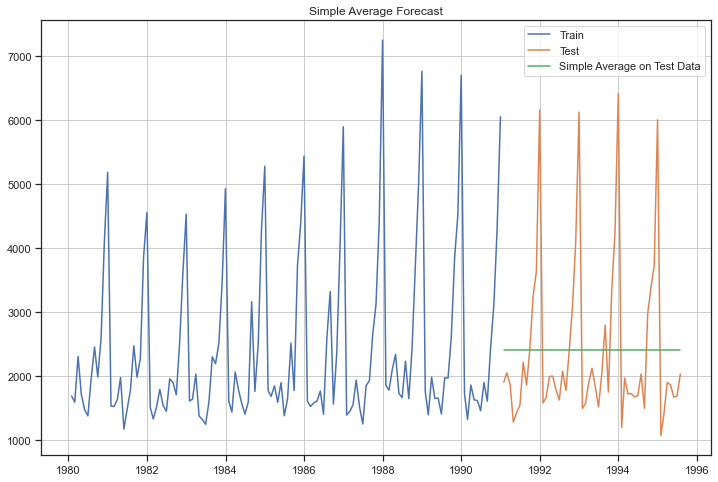

In [39]:
plt.figure(figsize=(12,8))
plt.plot(SimpleAverage_train['Sparkling'], label='Train')
plt.plot(SimpleAverage_test['Sparkling'], label='Test')
plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

**Model 3 - Simple Average Approach Evaluation (Defining the accuracy metrics)**

In [40]:
## Test Data - RMSE 

rmse_model3_test = metrics.mean_squared_error(test['Sparkling'],SimpleAverage_test['mean_forecast'],squared=False)
print("For Simple Average forecast on the Test Data,  RMSE is %3.3f" %(rmse_model3_test))

For Simple Average forecast on the Test Data,  RMSE is 1275.082


In [41]:
resultsDf_3 = pd.DataFrame({'Test RMSE': [rmse_model3_test]},index=['SimpleAverageModel'])

resultsDf = pd.concat([resultsDf, resultsDf_3])
resultsDf

Test RMSE
RegressionOnTime    1389.135175
NaiveModel          3864.279352
SimpleAverageModel  1275.081804

#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 4: Moving Average(MA)

*For the moving average model, we are going to calculate rolling means (or moving averages) for different intervals.  
The best interval can be determined by the maximum accuracy (or the minimum error) over here.*  

*For Moving Average, we are going to average over the entire data.*

In [42]:
MovingAverage = df.copy()
MovingAverage.head()

Sparkling
Time_Stamp           
1980-01-31       1686
1980-02-29       1591
1980-03-31       2304
1980-04-30       1712
1980-05-31       1471

*Trailing moving averages*

In [43]:
MovingAverage['Trailing_2'] = MovingAverage['Sparkling'].rolling(2).mean()
MovingAverage['Trailing_3'] = MovingAverage['Sparkling'].rolling(3).mean()
MovingAverage['Trailing_6'] = MovingAverage['Sparkling'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['Sparkling'].rolling(9).mean()

MovingAverage.head()

Sparkling  Trailing_2   Trailing_3  Trailing_6  Trailing_9
Time_Stamp                                                            
1980-01-31       1686         NaN          NaN         NaN         NaN
1980-02-29       1591      1638.5          NaN         NaN         NaN
1980-03-31       2304      1947.5  1860.333333         NaN         NaN
1980-04-30       1712      2008.0  1869.000000         NaN         NaN
1980-05-31       1471      1591.5  1829.000000         NaN         NaN

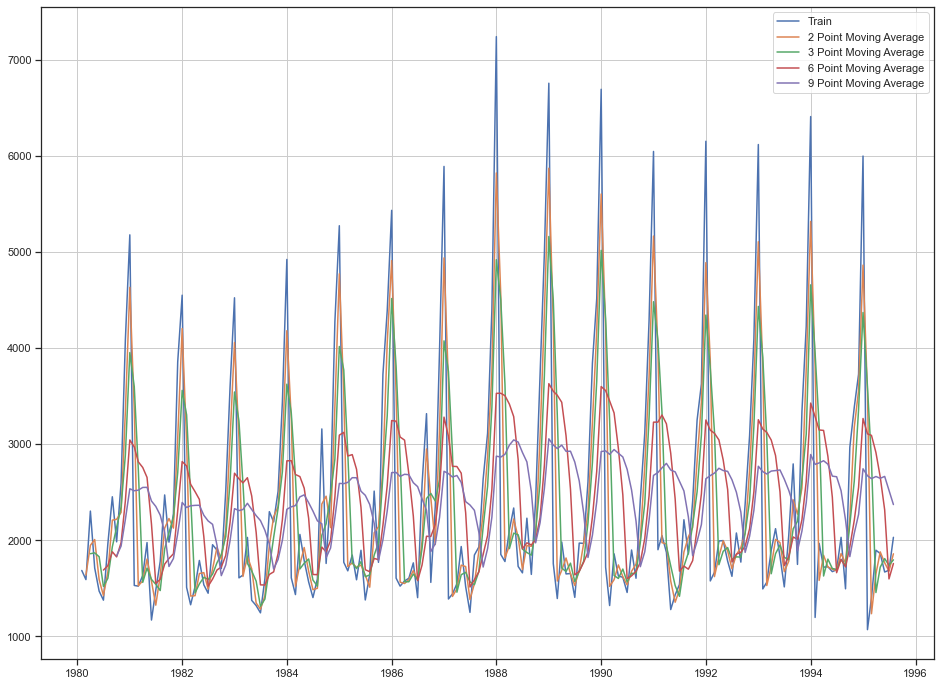

In [44]:
## Plotting on the whole data

plt.figure(figsize=(16,12))
plt.plot(MovingAverage['Sparkling'],label='Train')
plt.plot(MovingAverage['Trailing_2'],label='2 Point Moving Average')
plt.plot(MovingAverage['Trailing_3'],label='3 Point Moving Average')
plt.plot(MovingAverage['Trailing_6'],label ='6 Point Moving Average')
plt.plot(MovingAverage['Trailing_9'],label ='9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

Let us split the data into train and test and plot this Time Series. The window of the moving average is need to be carefully selected as too big a window will result in not having any test set as the whole series might get averaged over.

In [45]:
#Creating train and test set 
trailing_MovingAverage_train=MovingAverage[MovingAverage.index<'1991'] 
trailing_MovingAverage_test=MovingAverage[MovingAverage.index>='1991']

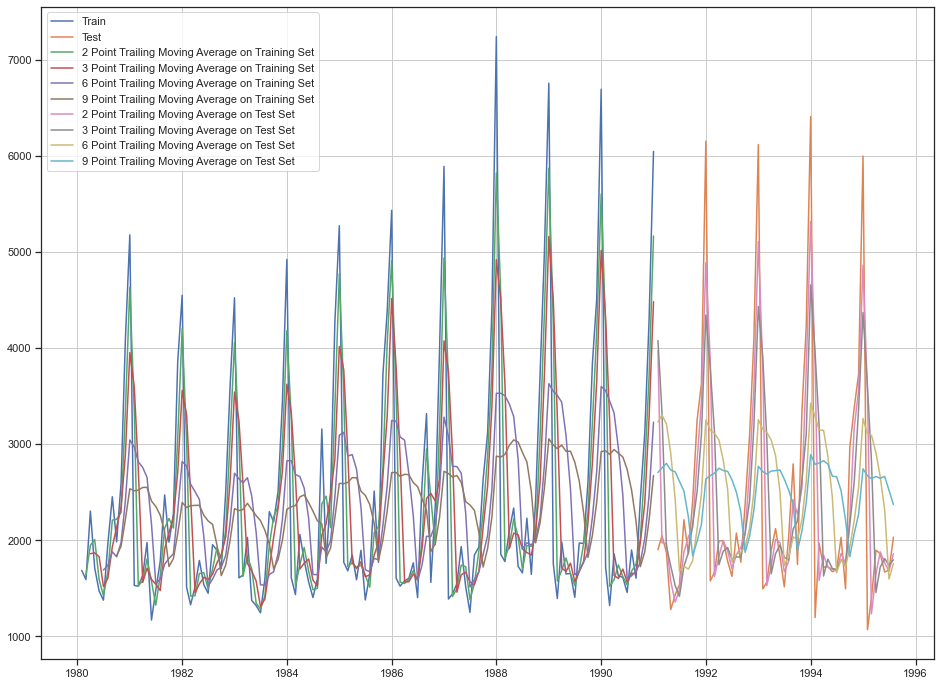

In [46]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,12))
plt.plot(trailing_MovingAverage_train['Sparkling'],label='Train')
plt.plot(trailing_MovingAverage_test['Sparkling'],label='Test')

plt.plot(trailing_MovingAverage_train['Trailing_2'],label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_3'],label='3 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_6'],label ='6 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_9'],label ='9 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test['Trailing_2'],label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_3'],label='3 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_6'],label ='6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_9'],label ='9 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid();

**Model 4 - Moving Average(MA) Approach Evaluation (Defining the accuracy metrics)**

In [47]:
## Test Data - RMSE --> 2 point Trailing MA

rmse_model4_test_2 = metrics.mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_2'],squared=False)
print("For 2 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_2))

## Test Data - RMSE  --> 3 point Trailing MA

rmse_model4_test_3 = metrics.mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_3'],squared=False)
print("For 3 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_3))

## Test Data - RMSE --> 6 point Trailing MA

rmse_model4_test_6 = metrics.mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_6'],squared=False)
print("For 6 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_6))

## Test Data - RMSE  --> 9 point Trailing MA

rmse_model4_test_9 = metrics.mean_squared_error(test['Sparkling'],trailing_MovingAverage_test['Trailing_9'],squared=False)
print("For 9 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f " %(rmse_model4_test_9))

For 2 point Moving Average Model forecast on the Training Data,  RMSE is 813.401
For 3 point Moving Average Model forecast on the Training Data,  RMSE is 1028.606
For 6 point Moving Average Model forecast on the Training Data,  RMSE is 1283.927
For 9 point Moving Average Model forecast on the Training Data,  RMSE is 1346.278 


***Done only on the test data***

In [48]:
resultsDf_4 = pd.DataFrame({'Test RMSE': [rmse_model4_test_2,rmse_model4_test_3
                                          ,rmse_model4_test_6,rmse_model4_test_9]}
                           ,index=['2pointTrailingMovingAverage','3pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])

resultsDf = pd.concat([resultsDf, resultsDf_4])
resultsDf

Test RMSE
RegressionOnTime             1389.135175
NaiveModel                   3864.279352
SimpleAverageModel           1275.081804
2pointTrailingMovingAverage   813.400684
3pointTrailingMovingAverage  1028.605756
6pointTrailingMovingAverage  1283.927428
9pointTrailingMovingAverage  1346.278315

## Before we go on to build the various Exponential Smoothing models, let us plot all the models and compare the Time Series plots.

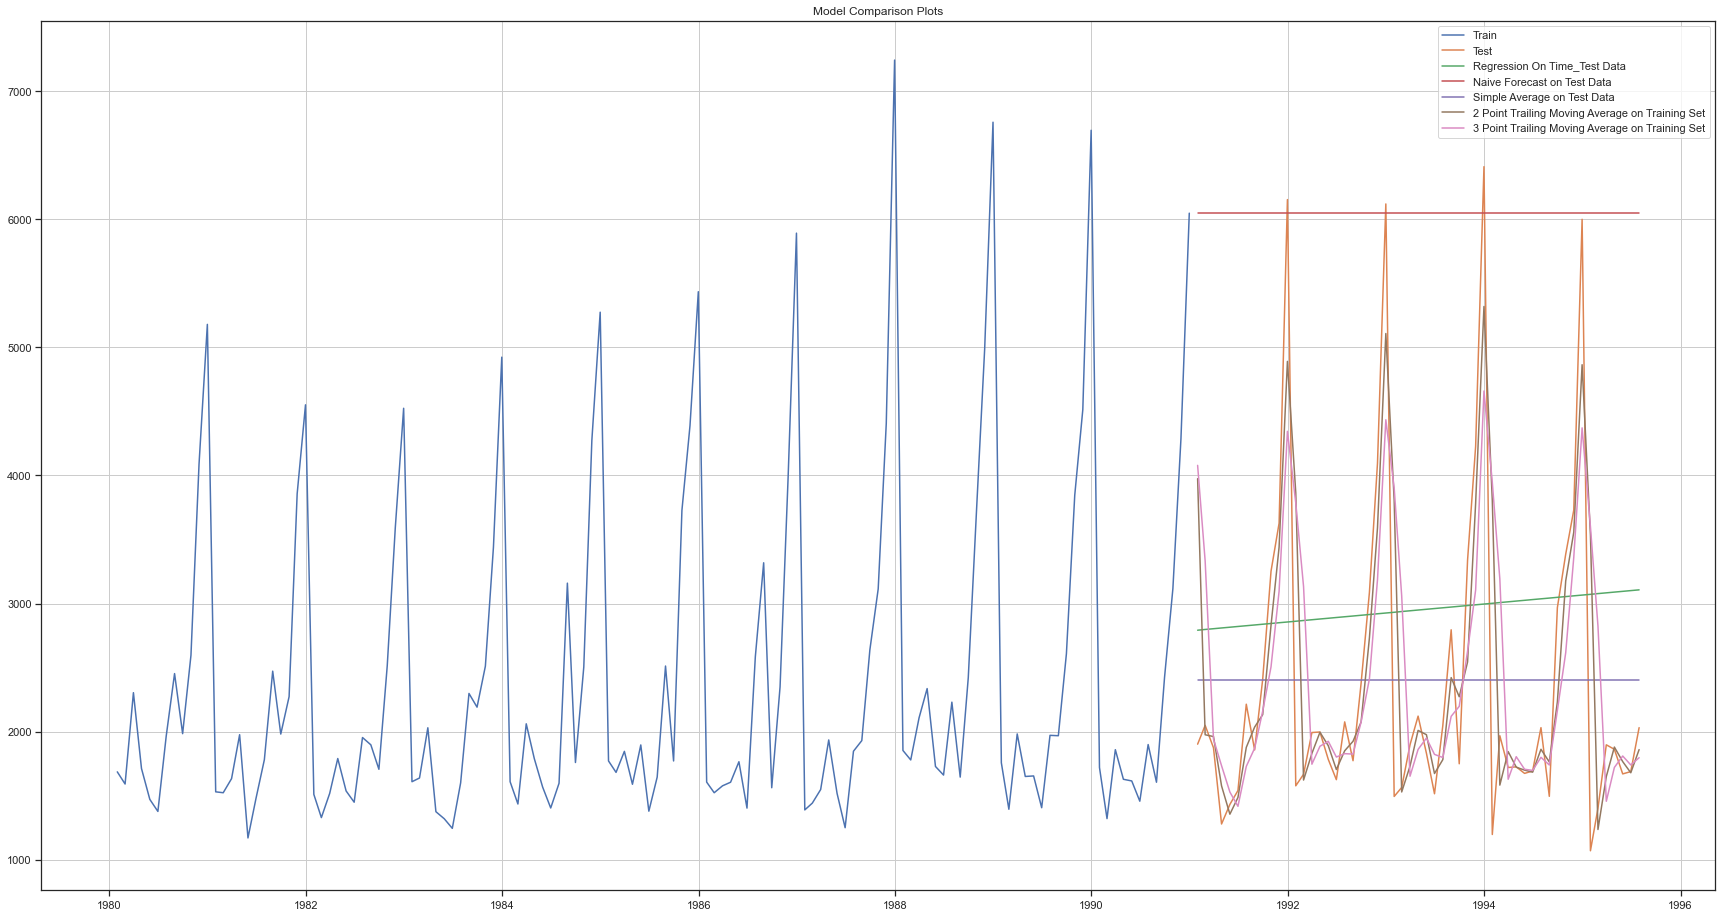

In [49]:
## Plotting on both Training and Test data

plt.figure(figsize=(30,16))
plt.plot(train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')

plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')

plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')

plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')

plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test['Trailing_3'], label='3 Point Trailing Moving Average on Training Set')

plt.legend(loc='best')
plt.title("Model Comparison Plots")
plt.grid();

So far, '2 Point Trailing Moving Average' has faired well which is visible on the lowest RMSE as well on the fit on test data.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#1E90FF;">Exponential Smoothing Models

#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 5: Simple Exponetial Smoothing method (SES)

In [50]:
SES_train = train.copy()
SES_test = test.copy()

In [51]:
model_SES = SimpleExpSmoothing(SES_train['Sparkling'])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [52]:
model_SES_autofit = model_SES.fit(optimized=True)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [53]:
model_SES_autofit.params

{'smoothing_level': 0.04960659880745982,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1818.5047538435374,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [54]:
SES_test['predict'] = model_SES_autofit.forecast(steps=len(test))
SES_test.head()

Sparkling      predict
Time_Stamp                        
1991-01-31       1902  2724.929339
1991-02-28       2049  2724.929339
1991-03-31       1874  2724.929339
1991-04-30       1279  2724.929339
1991-05-31       1432  2724.929339

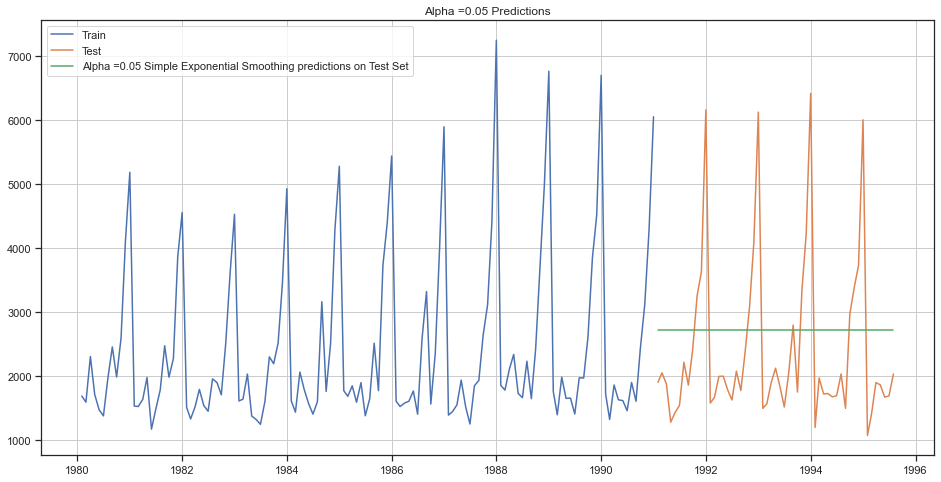

In [55]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(SES_train['Sparkling'], label='Train')
plt.plot(SES_test['Sparkling'], label='Test')

plt.plot(SES_test['predict'], label='Alpha =0.05 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha =0.05 Predictions');

**Model 5 - SES Evaluation for  𝛼 = 0.05 : Simple Exponential Smoothing**

In [56]:
## Test Data

rmse_model5_test_1 = metrics.mean_squared_error(SES_test['Sparkling'],SES_test['predict'],squared=False)
print("For Alpha =0.05 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is %3.3f" %(rmse_model5_test_1))



For Alpha =0.05 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is 1316.035


In [57]:
resultsDf_5 = pd.DataFrame({'Test RMSE': [rmse_model5_test_1]},index=['Alpha=0.05,SimpleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_5])
resultsDf

Test RMSE
RegressionOnTime                       1389.135175
NaiveModel                             3864.279352
SimpleAverageModel                     1275.081804
2pointTrailingMovingAverage             813.400684
3pointTrailingMovingAverage            1028.605756
6pointTrailingMovingAverage            1283.927428
9pointTrailingMovingAverage            1346.278315
Alpha=0.05,SimpleExponentialSmoothing  1316.034674

***Setting different alpha values***

Remember,higher the alpha value, more weightage is given to the more recent observation.   
That means, what happened recently will happen again.  

We will run a loop with different alpha values to understand which particular value works best for alpha on the test set.

In [58]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_6 = pd.DataFrame({'Alpha Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_6

Empty DataFrame
Columns: [Alpha Values, Train RMSE, Test RMSE]
Index: []

In [59]:
for i in np.arange(0.3,1,0.1):
    model_SES_alpha_i = model_SES.fit(smoothing_level=i,optimized=False,use_brute=True)
    SES_train['predict',i] = model_SES_alpha_i.fittedvalues
    SES_test['predict',i] = model_SES_alpha_i.forecast(steps=len(SES_test))
    
    rmse_model5_train_i = metrics.mean_squared_error(SES_train['Sparkling'],SES_train['predict',i],squared=False)
    
    rmse_model5_test_i = metrics.mean_squared_error(SES_test['Sparkling'],SES_test['predict',i],squared=False)
    
    resultsDf_6 = resultsDf_6.append({'Alpha Values':i,'Train RMSE':rmse_model5_train_i 
                                      ,'Test RMSE':rmse_model5_test_i}, ignore_index=True)

In [60]:
resultsDf_6.sort_values(by=['Test RMSE'],ascending=True)

Alpha Values   Train RMSE    Test RMSE
0           0.3  1359.511747  1935.507132
1           0.4  1352.588879  2311.919615
2           0.5  1344.004369  2666.351413
3           0.6  1338.805381  2979.204388
4           0.7  1338.844308  3249.944092
5           0.8  1344.462091  3483.801006
6           0.9  1355.723518  3686.794285

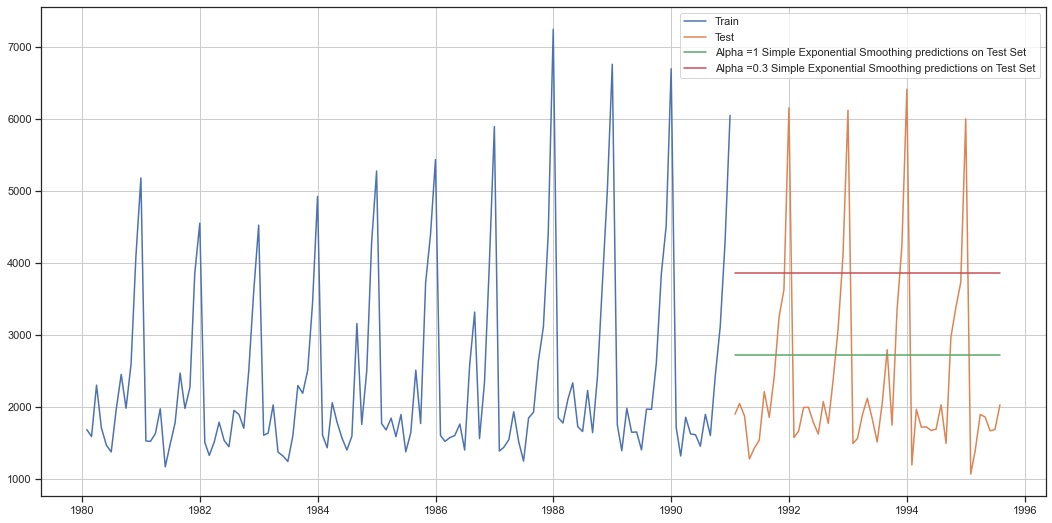

In [61]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(SES_train['Sparkling'], label='Train')
plt.plot(SES_test['Sparkling'], label='Test')

plt.plot(SES_test['predict'], label='Alpha =1 Simple Exponential Smoothing predictions on Test Set')

plt.plot(SES_test['predict', 0.3], label='Alpha =0.3 Simple Exponential Smoothing predictions on Test Set')



plt.legend(loc='best')
plt.grid();

In [62]:
resultsDf_6_1 = pd.DataFrame({'Test RMSE': [resultsDf_6.sort_values(by=['Test RMSE'],ascending=True).values[0][2]]}
                           ,index=['Alpha=0.3,SimpleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_6_1])
resultsDf

Test RMSE
RegressionOnTime                       1389.135175
NaiveModel                             3864.279352
SimpleAverageModel                     1275.081804
2pointTrailingMovingAverage             813.400684
3pointTrailingMovingAverage            1028.605756
6pointTrailingMovingAverage            1283.927428
9pointTrailingMovingAverage            1346.278315
Alpha=0.05,SimpleExponentialSmoothing  1316.034674
Alpha=0.3,SimpleExponentialSmoothing   1935.507132

In [63]:
resultsDf.sort_values(by=['Test RMSE']).head(12)

Test RMSE
2pointTrailingMovingAverage             813.400684
3pointTrailingMovingAverage            1028.605756
SimpleAverageModel                     1275.081804
6pointTrailingMovingAverage            1283.927428
Alpha=0.05,SimpleExponentialSmoothing  1316.034674
9pointTrailingMovingAverage            1346.278315
RegressionOnTime                       1389.135175
Alpha=0.3,SimpleExponentialSmoothing   1935.507132
NaiveModel                             3864.279352

#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 6: Double Exponetial Smoothing Method (DES/Holt's Meodel)

***Two parameters $\alpha$ and $\beta$ are estimated in this model. Level and Trend are accounted for in this model.***

In [64]:
DES_train = train.copy()
DES_test = test.copy()

In [65]:
model_DES = Holt(DES_train['Sparkling'])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [66]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_7 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_7

Empty DataFrame
Columns: [Alpha Values, Beta Values, Train RMSE, Test RMSE]
Index: []

In [67]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_trend=j,optimized=False,use_brute=True)
        DES_train['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test['predict',i,j] = model_DES_alpha_i_j.forecast(steps=len(DES_test))
        
        rmse_model6_train = metrics.mean_squared_error(DES_train['Sparkling'],DES_train['predict',i,j],squared=False)
        
        rmse_model6_test = metrics.mean_squared_error(DES_test['Sparkling'],DES_test['predict',i,j],squared=False)
        
        resultsDf_7 = resultsDf_7.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model6_train
                                          ,'Test RMSE':rmse_model6_test}, ignore_index=True)

In [68]:
resultsDf_7

Alpha Values  Beta Values   Train RMSE     Test RMSE
0            0.3          0.3  1592.292788  18259.110704
1            0.3          0.4  1682.573828  26069.841401
2            0.3          0.5  1771.710791  34401.512440
3            0.3          0.6  1848.576510  42162.748095
4            0.3          0.7  1899.949006  47832.397419
..           ...          ...          ...           ...
59           1.0          0.6  1753.402326  49327.087977
60           1.0          0.7  1825.187155  52655.765663
61           1.0          0.8  1902.013709  55442.273880
62           1.0          0.9  1985.368445  57823.177011
63           1.0          1.0  2077.672157  59877.076519

[64 rows x 4 columns]

We shall sort the data frame in the ascending ordering of the 'Test RMSE' values.

In [69]:
resultsDf_7.sort_values(by=['Test RMSE']).head()

Alpha Values  Beta Values   Train RMSE     Test RMSE
0            0.3          0.3  1592.292788  18259.110704
8            0.4          0.3  1569.338606  23878.496940
1            0.3          0.4  1682.573828  26069.841401
16           0.5          0.3  1530.575845  27095.532414
24           0.6          0.3  1506.449870  29070.722592

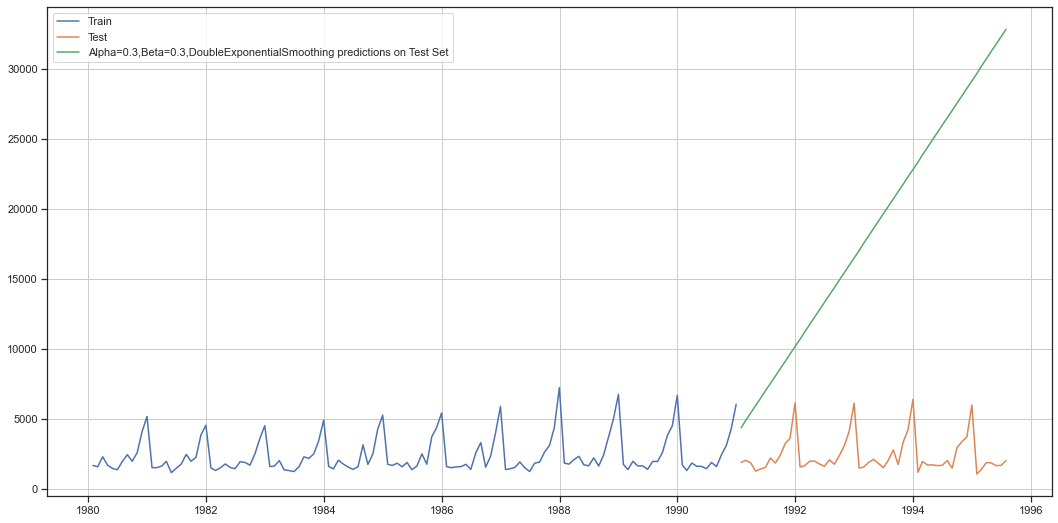

In [70]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(DES_train['Sparkling'], label='Train')
plt.plot(DES_test['Sparkling'], label='Test')

plt.plot(DES_test['predict', 0.3, 0.3], label='Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [71]:
resultsDf_7_1 = pd.DataFrame({'Test RMSE': [resultsDf_7.sort_values(by=['Test RMSE']).values[0][3]]}
                           ,index=['Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_7_1])
resultsDf.sort_values(by=['Test RMSE']).head(12)

Test RMSE
2pointTrailingMovingAverage                      813.400684
3pointTrailingMovingAverage                     1028.605756
SimpleAverageModel                              1275.081804
6pointTrailingMovingAverage                     1283.927428
Alpha=0.05,SimpleExponentialSmoothing           1316.034674
9pointTrailingMovingAverage                     1346.278315
RegressionOnTime                                1389.135175
Alpha=0.3,SimpleExponentialSmoothing            1935.507132
NaiveModel                                      3864.279352
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing  18259.110704

#### <span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:#1E90FF;">Model 7: Triple Exponential Smoothing (Holt - Winter's Model)

##### Three parameters $\alpha$, $\beta$ and $\gamma$ are estimated in this model. Level, Trend and Seasonality are accounted for in this model.

In [72]:
TES_train = train.copy()
TES_test = test.copy()

In [73]:
model_TES = ExponentialSmoothing(TES_train['Sparkling'],trend='additive',seasonal='multiplicative',freq='M')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [74]:
model_TES_autofit = model_TES.fit()

In [75]:
model_TES_autofit.params

{'smoothing_level': 0.11107308290744182,
 'smoothing_trend': 0.06167745801641925,
 'smoothing_seasonal': 0.39488777704116057,
 'damping_trend': nan,
 'initial_level': 1639.5306320456996,
 'initial_trend': -13.803739314239138,
 'initial_seasons': array([1.04411064, 1.00095858, 1.40459398, 1.20906039, 0.96413947,
        0.96754964, 1.3048211 , 1.69841076, 1.37034155, 1.81659752,
        2.84708154, 3.62462473]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [76]:
## Prediction on the test data

TES_test['auto_predict'] = model_TES_autofit.forecast(steps=len(TES_test))
TES_test.head()

Sparkling  auto_predict
Time_Stamp                         
1991-01-31       1902   1577.287560
1991-02-28       2049   1333.740806
1991-03-31       1874   1746.024831
1991-04-30       1279   1630.595491
1991-05-31       1432   1523.372422

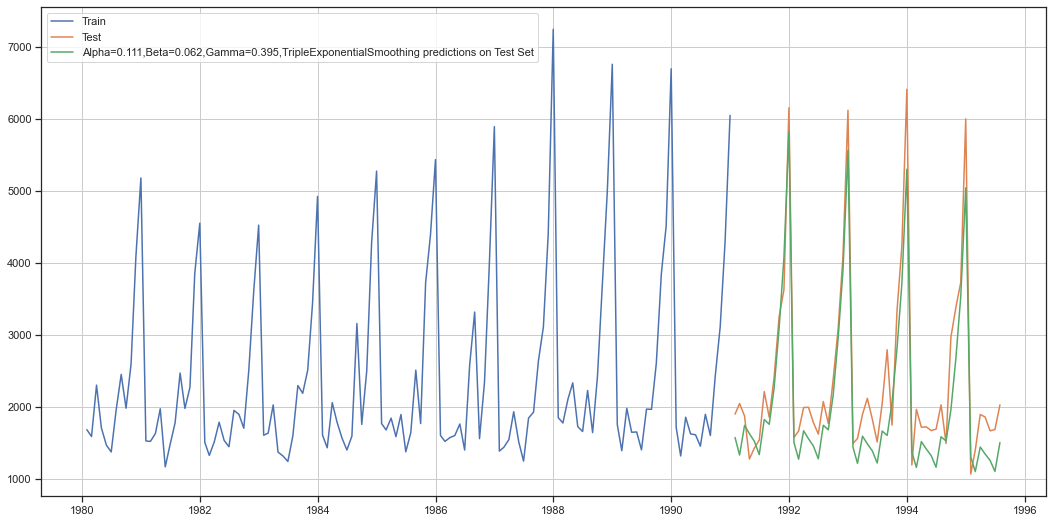

In [77]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(TES_train['Sparkling'], label='Train')
plt.plot(TES_test['Sparkling'], label='Test')

plt.plot(TES_test['auto_predict'], label='Alpha=0.111,Beta=0.062,Gamma=0.395,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [78]:
## Test Data

rmse_model6_test_1 = metrics.mean_squared_error(TES_test['Sparkling'],TES_test['auto_predict'],squared=False)
print("For Alpha=0.111,Beta=0.062,Gamma=0.395,Triple Exponential Smoothing Model forecast on Test Data,RMSE is %3.3f" %(rmse_model6_test_1))

For Alpha=0.111,Beta=0.062,Gamma=0.395,Triple Exponential Smoothing Model forecast on Test Data,RMSE is 469.432


In [79]:
resultsDf_8_1 = pd.DataFrame({'Test RMSE': [rmse_model6_test_1]}
                           ,index=['Alpha=0.111,Beta=0.062,Gamma=0.395,TripleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_8_1])
resultsDf.sort_values(by=['Test RMSE']).head(12)

Test RMSE
Alpha=0.111,Beta=0.062,Gamma=0.395,TripleExpone...    469.432003
2pointTrailingMovingAverage                           813.400684
3pointTrailingMovingAverage                          1028.605756
SimpleAverageModel                                   1275.081804
6pointTrailingMovingAverage                          1283.927428
Alpha=0.05,SimpleExponentialSmoothing                1316.034674
9pointTrailingMovingAverage                          1346.278315
RegressionOnTime                                     1389.135175
Alpha=0.3,SimpleExponentialSmoothing                 1935.507132
NaiveModel                                           3864.279352
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing       18259.110704

***Finding the best Alpha,Beta,Gamma value for TES***

In [80]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_8_2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_8_2

Empty DataFrame
Columns: [Alpha Values, Beta Values, Gamma Values, Train RMSE, Test RMSE]
Index: []

In [81]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
            TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=len(TES_test))
        
            rmse_model8_train = metrics.mean_squared_error(TES_train['Sparkling'],TES_train['predict',i,j,k],squared=False)
            
            rmse_model8_test = metrics.mean_squared_error(TES_test['Sparkling'],TES_test['predict',i,j,k],squared=False)
            
            resultsDf_8_2 = resultsDf_8_2.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k,
                                                  'Train RMSE':rmse_model8_train,'Test RMSE':rmse_model8_test}
                                                 , ignore_index=True)

In [82]:
resultsDf_8_2.sort_values(by=['Test RMSE']).head(12)

Alpha Values  Beta Values  Gamma Values  Train RMSE   Test RMSE
0             0.3          0.3           0.3  404.513320  392.786198
8             0.3          0.4           0.3  424.828055  410.854547
65            0.4          0.3           0.4  435.553595  421.409170
296           0.7          0.8           0.3  700.317756  518.188752
130           0.5          0.3           0.5  498.239915  542.175497
464           1.0          0.5           0.3  702.568248  579.074932
134           0.5          0.3           0.9  901.166743  597.528174
73            0.4          0.4           0.4  476.407064  635.614430
409           0.9          0.6           0.4  843.129366  681.796439
16            0.3          0.5           0.3  453.540157  721.942699
18            0.3          0.5           0.5  446.487495  758.856380
76            0.4          0.4           0.7  569.422992  893.468525

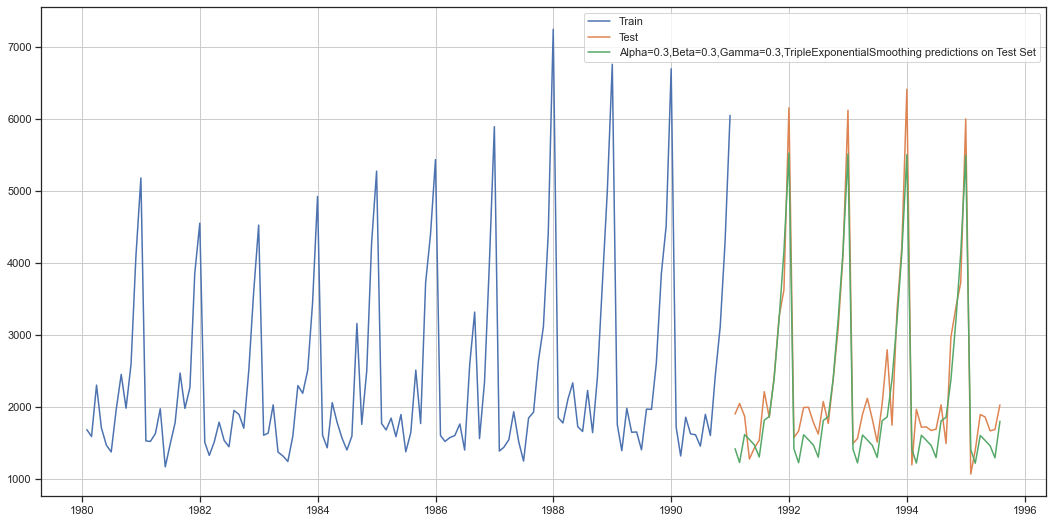

In [83]:
## Plotting on both the Training and Test data using brute force alpha, beta and gamma determination

plt.figure(figsize=(18,9))
plt.plot(TES_train['Sparkling'], label='Train')
plt.plot(TES_test['Sparkling'], label='Test')

#The value of alpha and beta is taken like that by python
plt.plot(TES_test['predict', 0.3, 0.3, 0.3], label='Alpha=0.3,Beta=0.3,Gamma=0.3,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [84]:
resultsDf_8_3 = pd.DataFrame({'Test RMSE': [resultsDf_8_2.sort_values(by=['Test RMSE']).values[0][4]]}
                           ,index=['Alpha=0.3,Beta=0.3,Gamma=0.3,TripleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_8_3])
resultsDf.sort_values(by=['Test RMSE']).head(15)

Test RMSE
Alpha=0.3,Beta=0.3,Gamma=0.3,TripleExponentialS...    392.786198
Alpha=0.111,Beta=0.062,Gamma=0.395,TripleExpone...    469.432003
2pointTrailingMovingAverage                           813.400684
3pointTrailingMovingAverage                          1028.605756
SimpleAverageModel                                   1275.081804
6pointTrailingMovingAverage                          1283.927428
Alpha=0.05,SimpleExponentialSmoothing                1316.034674
9pointTrailingMovingAverage                          1346.278315
RegressionOnTime                                     1389.135175
Alpha=0.3,SimpleExponentialSmoothing                 1935.507132
NaiveModel                                           3864.279352
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing       18259.110704

For this data set, we had both trend and seasonality, so by definition Triple Exponential Smoothing is supposed to work better than the Simple Exponential Smoothing as well as the Double Exponential Smoothing.  

However, since this was a model building exercise we had gone on to build different models on the data and have compared these model with the best RMSE value on the test data.

We see that the best model is the Triple Exponential Smoothing with multiplicative seasonality with the parameters  𝛼 = 0.3,  𝛽 = 0.3 and  𝛾 = 0.3.

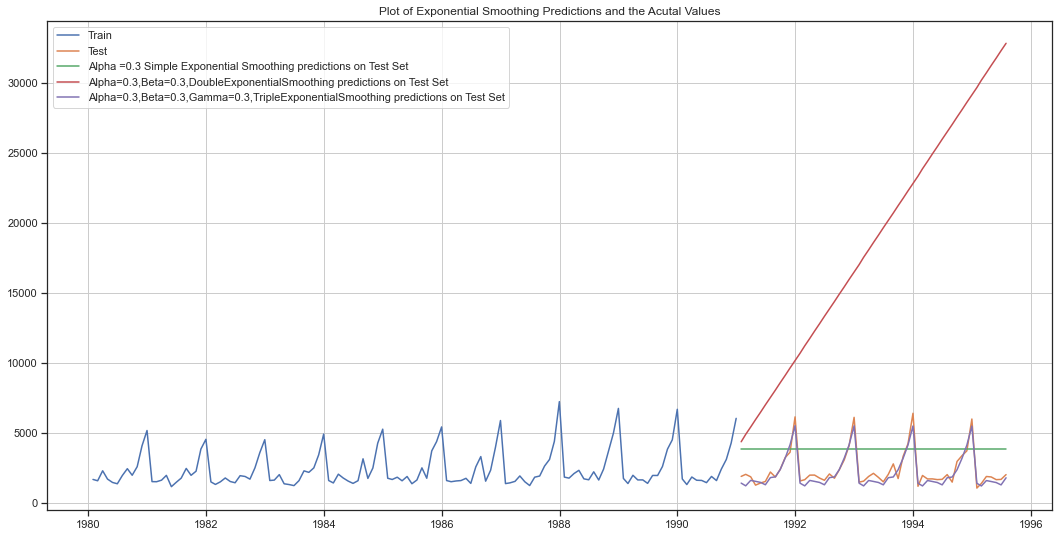

In [85]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')

plt.plot(SES_test['predict', 0.3], label='Alpha =0.3 Simple Exponential Smoothing predictions on Test Set')

plt.plot(DES_test['predict', 0.3, 0.3], label='Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing predictions on Test Set')

plt.plot(TES_test['predict', 0.3, 0.3, 0.3], label='Alpha=0.3,Beta=0.3,Gamma=0.3,TripleExponentialSmoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid();
plt.title('Plot of Exponential Smoothing Predictions and the Acutal Values');

In this particular we have built several models and went through a model building exercise. This particular exercise has given us an idea as to which particular model gives us the least error on our test set for this data.   

However,in Time Series Forecasting, we need to be highly vigil about the fact that, after we have done this exercise we need to build the model on the whole data.  

Remember, the training data that we have used to build the model stops much before the data ends.  

In order to forecast using any of the models built, we need to build the models again (this time on the complete data) with the same parameters.

For this particular dataset, we will go ahead and build only the top 2 models which gave us the best accuracy (least RMSE).  

    1. Alpha=0.3,Beta=0.3,Gamma=0.3,TripleExponentialSmoothing	    -  392.786198
    2. Alpha=0.111,Beta=0.062,Gamma=0.395,TripleExponentialSmoothing  -  469.432003

***Building full model on the whole data***

In [86]:
fullmodel1 = ExponentialSmoothing(df,
                                  trend='additive',
                                  seasonal='multiplicative').fit(smoothing_level=0.3,
                                                                 smoothing_trend=0.3,
                                                                 smoothing_seasonal=0.3)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [87]:
RMSE_fullmodel1 = metrics.mean_squared_error(df['Sparkling'],fullmodel1.fittedvalues,squared=False)

print('RMSE:',RMSE_fullmodel1)

RMSE: 421.30973568581123


In [88]:
# Getting the predictions for the same number of times stamps that are present in the test data
prediction_1 = fullmodel1.forecast(steps=len(test))

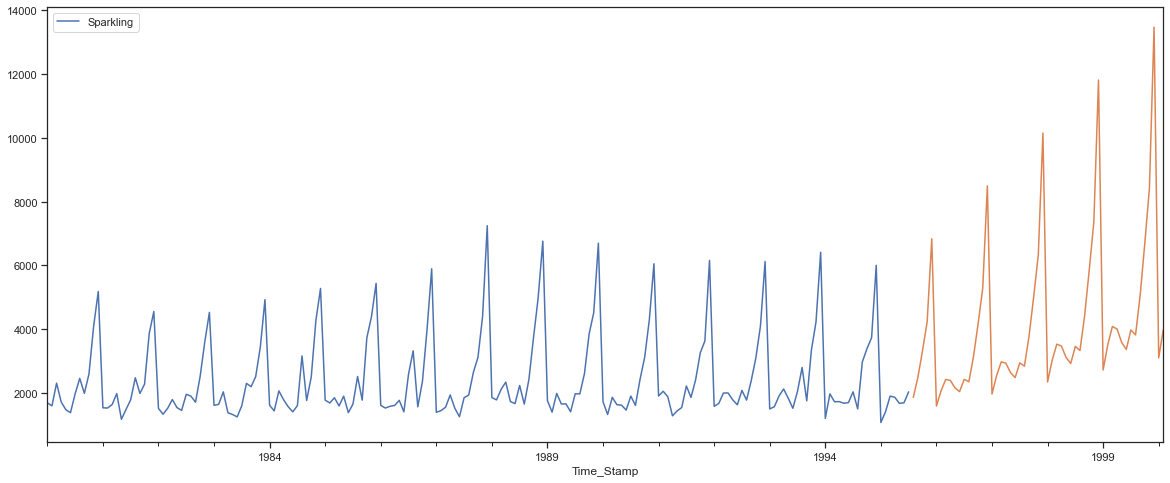

In [89]:
df.plot()
prediction_1.plot();

In [90]:
#In the below code, we have calculated the upper and lower confidence bands at 95% confidence level
#Here we are taking the multiplier to be 1.96 as we want to plot with respect to a 95% confidence intervals.
pred_1_df = pd.DataFrame({'lower_CI':prediction_1 - 1.96*np.std(fullmodel1.resid,ddof=1),
                          'prediction':prediction_1,
                          'upper_ci': prediction_1 + 1.96*np.std(fullmodel1.resid,ddof=1)})
pred_1_df.head()

lower_CI   prediction     upper_ci
1995-08-31  1027.496371  1855.475048  2683.453725
1995-09-30  1659.259187  2487.237864  3315.216541
1995-10-31  2496.258736  3324.237414  4152.216091
1995-11-30  3399.112466  4227.091144  5055.069821
1995-12-31  6003.568373  6831.547050  7659.525727

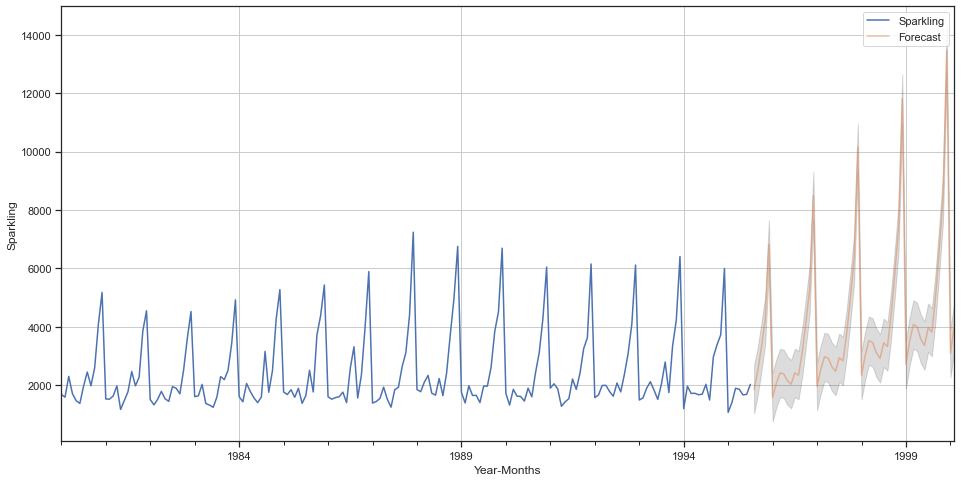

In [91]:
# plot the forecast along with the confidence band

axis = df.plot(label='Actual', figsize=(16,8))
pred_1_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_1_df.index, pred_1_df['lower_CI'], pred_1_df['upper_ci'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Sparkling')
plt.legend(loc='best')
plt.grid()
plt.show()

We shall now build the second model,using the same parameters on the full data and check the confidence bands when we forecast into the future for the length of the test set.

In [92]:
fullmodel2 = ExponentialSmoothing(df,
                                  trend='additive',
                                  seasonal='multiplicative').fit(smoothing_level=0.111,
                                                                 smoothing_trend=0.062,
                                                                 smoothing_seasonal=0.395)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [93]:
RMSE_fullmodel2 = metrics.mean_squared_error(df['Sparkling'],fullmodel2.fittedvalues,squared=False)

print('RMSE:',RMSE_fullmodel2)

RMSE: 353.44298546403735


In [94]:
# Getting the predictions for the same number of times stamps that are present in the test data
prediction_2 = fullmodel2.forecast(steps=len(test))

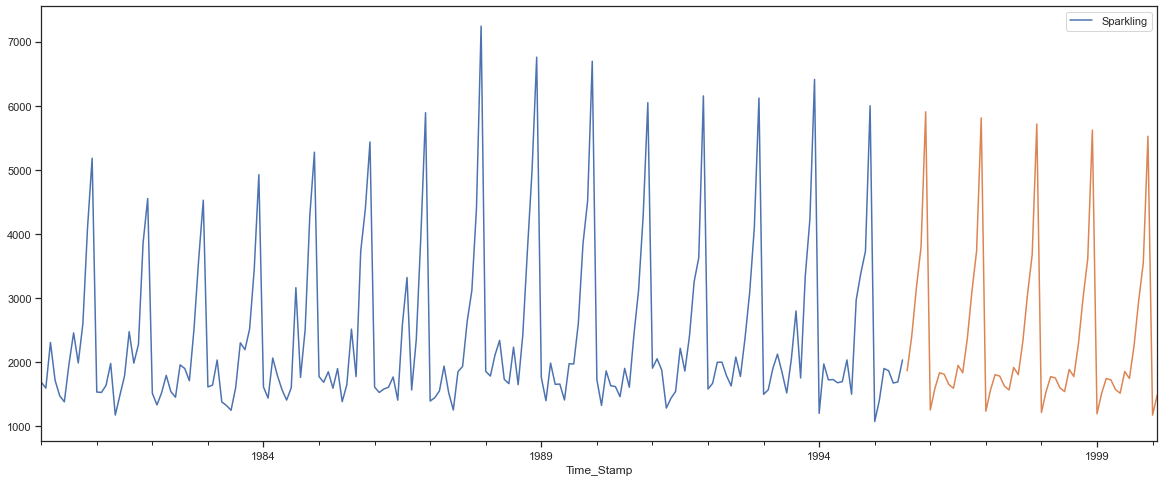

In [95]:
df.plot()
prediction_2.plot();

In [96]:
#In the below code, we have calculated the upper and lower confidence bands at 95% confidence level
#The percentile function under numpy lets us calculate these and adding and subtracting from the predictions
#gives us the necessary confidence bands for the predictions
pred_2_df = pd.DataFrame({'lower_CI':prediction_2 - 1.96*np.std(fullmodel1.resid,ddof=1),
                          'prediction':prediction_2,
                          'upper_ci': prediction_2 + 1.96*np.std(fullmodel1.resid,ddof=1)})
pred_2_df.head()

lower_CI   prediction     upper_ci
1995-08-31  1032.863181  1860.841858  2688.820536
1995-09-30  1577.801573  2405.780250  3233.758927
1995-10-31  2331.365499  3159.344177  3987.322854
1995-11-30  2964.406237  3792.384914  4620.363592
1995-12-31  5076.523298  5904.501975  6732.480652

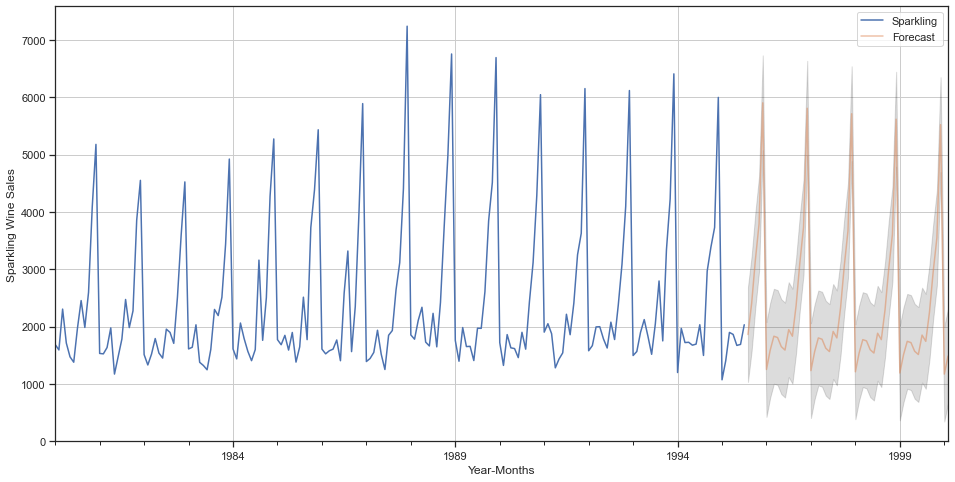

In [97]:
# plot the forecast along with the confidence band

axis = df.plot(label='Actual', figsize=(16,8))
pred_2_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_2_df.index, pred_2_df['lower_CI'], pred_2_df['upper_ci'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Sparkling Wine Sales')
plt.legend(loc='best')
plt.grid()
plt.show()

From the above 2 model building on Triple Exponential Smoothing methods, the TES with Auto-fit alpha, beta, gamma values have faired well with lowest RMSE value of 353.443. Also from the above graph, the Forecast is in line with the Test data.

However since seasonility is present also to make a model build better, let's try to run the ARIMA/SARIMA models too and conclude on the optimal model for Forecasting. 



#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#4B0082;">5. Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment. Note: Stationarity should be checked at alpha = 0.05.

Before we run the ARIMA/SARIMA models, we need to check the condition for stationarity.

<b>Why do we need to check for stationarity?</b>

A Time Series is considered to be stationary whose statistical properties such as the variance and (auto) correlation are all constant over time.   
The properties of a stationary time series do not depend on time.   
The (auto) correlation observations only depend on how far apart these observations are and not where they are.  

The intuitive understanding of the importance of stationarity is that the coefficients of the AR model should not be biased because the Time Series has a pronounced trend or seasonality.  

A Time Series with a pronounced trend is not going to have a similar mean everywhere across the observed the time frame. This means that the entire Time Series is not part of the same sample which is a need for a regression model.  

***To check whether the series is stationary, we use the Augmented Dickey Fuller (ADF) test whose null and alternate hypothesis can be simplified to***

• Null Hypothesis H0 : Time Series is non-stationary   
• Alternate Hypothesis Ha : Time Series is stationary  
    
At our desired level of significance (chosen alpha value), we can test for stationarity using the ADF test.

**Check for stationarity of the whole Time Series data**

In [98]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window=7).std()   #determining the rolling standard deviation

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

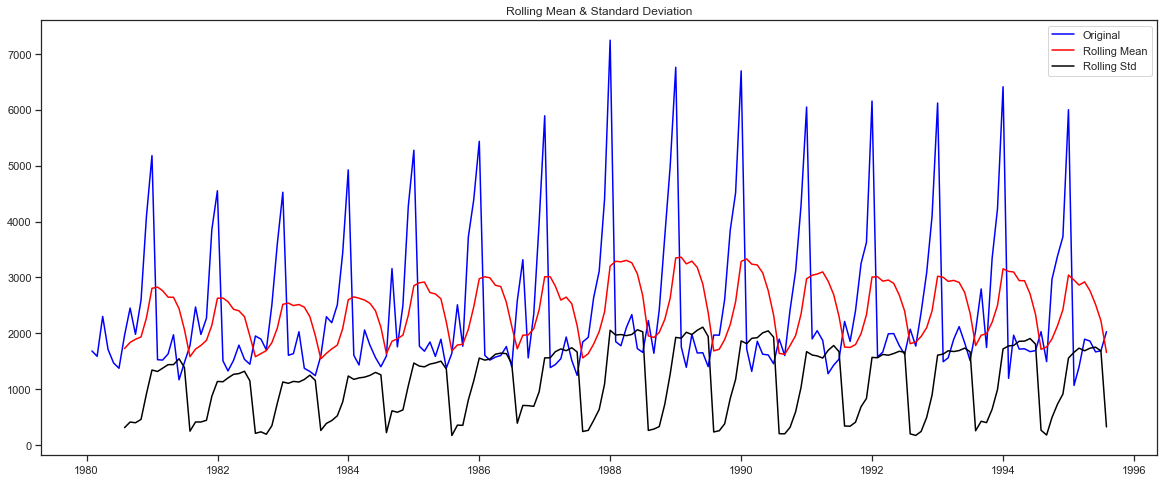

Results of Dickey-Fuller Test:
Test Statistic                  -1.360497
p-value                          0.601061
#Lags Used                      11.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64 



In [99]:
test_stationarity(df['Sparkling'])

We see that at 5% significant level the Time Series is non-stationary.

We shall take a difference of order 1 and check whether the Time Series is stationary or not.

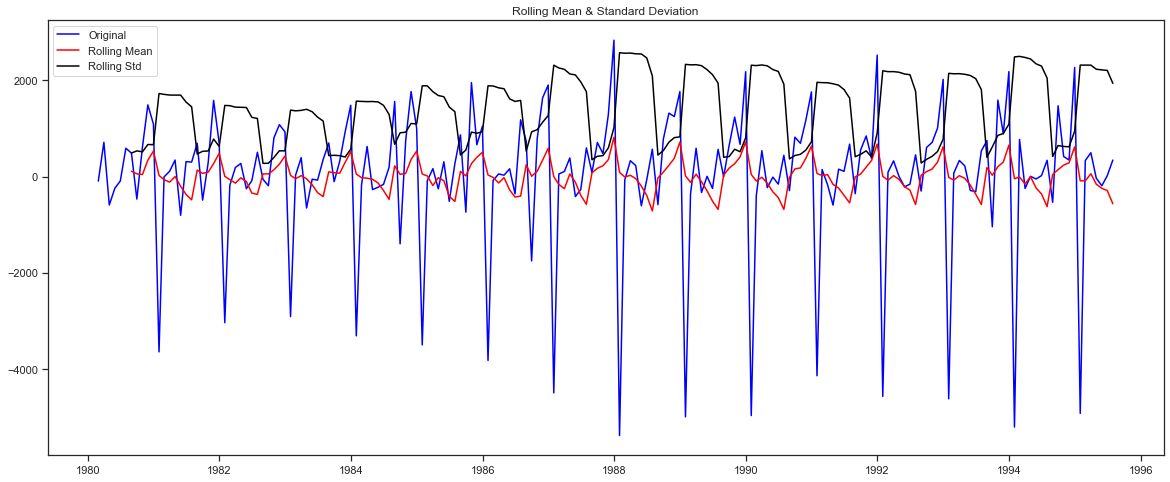

Results of Dickey-Fuller Test:
Test Statistic                 -45.050301
p-value                          0.000000
#Lags Used                      10.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64 



In [100]:
test_stationarity(df['Sparkling'].diff().dropna())

We see that at $\alpha$ = 0.05 the Time Series is indeed stationary.

#### Plotting the Autocorrelation and the Partial Autocorrelation function plots on the whole data.

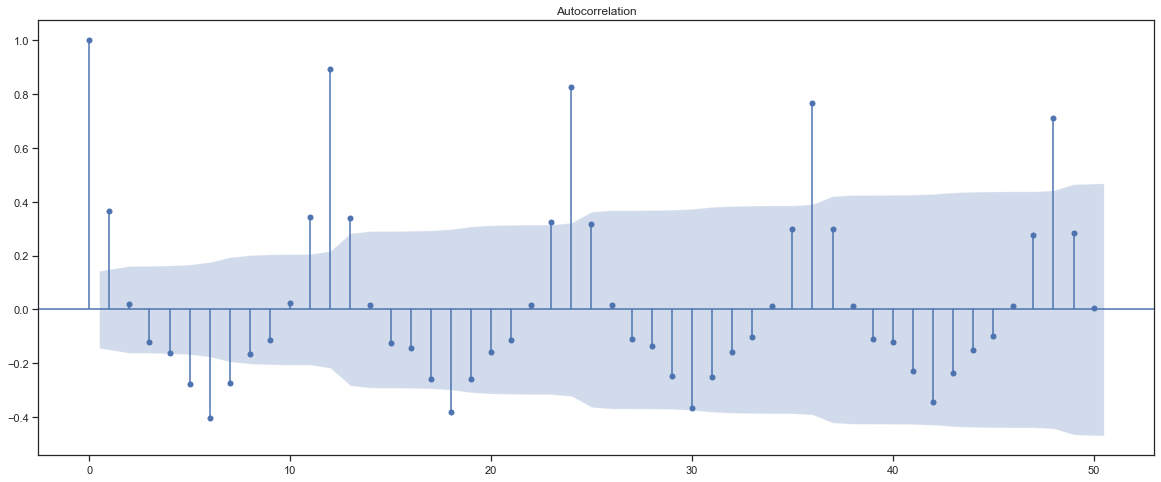

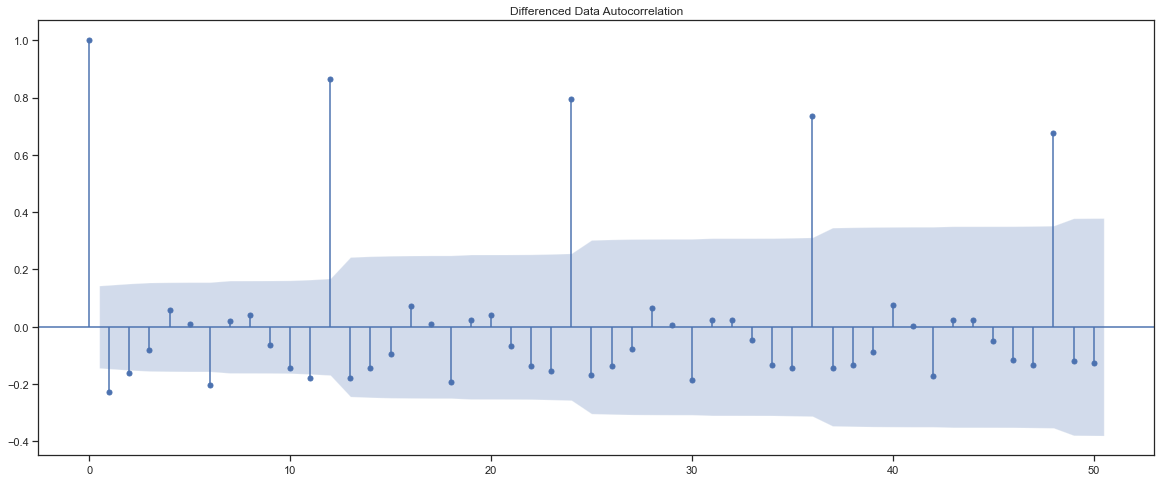

In [101]:
plot_acf(df['Sparkling'],lags=50)
plot_acf(df['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


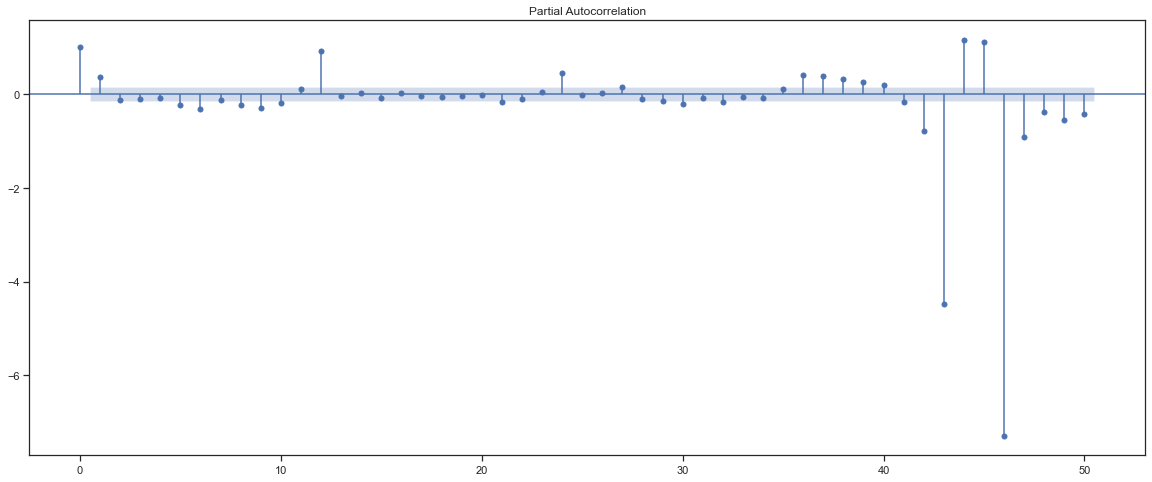

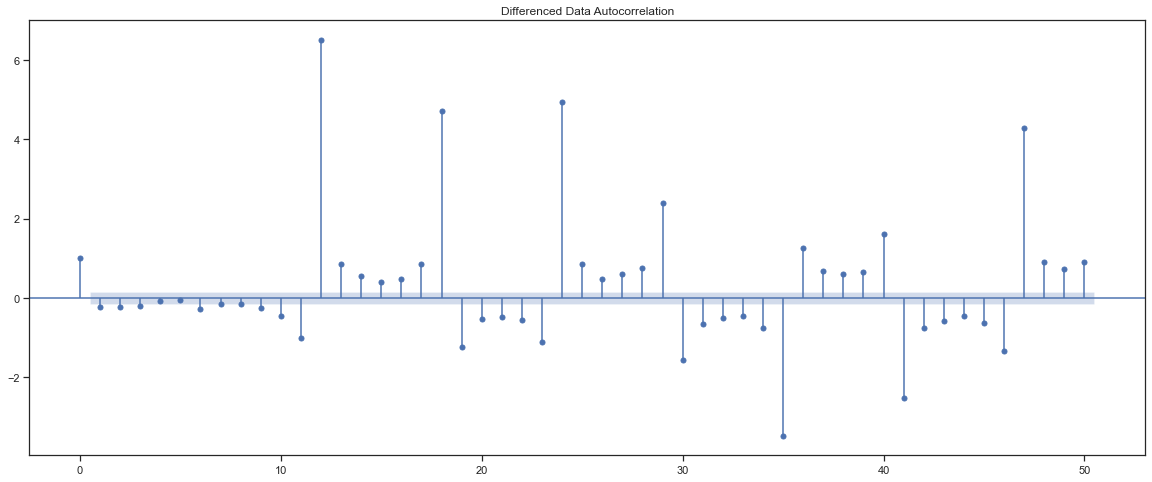

In [102]:
plot_pacf(df['Sparkling'],lags=50)
plot_pacf(df['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()

From the above plots, we can say that there seems to be a seasonality in the data.

### From the Splitting done on data into train and test and plotting the training and test data for ARIMA/SARIMA models

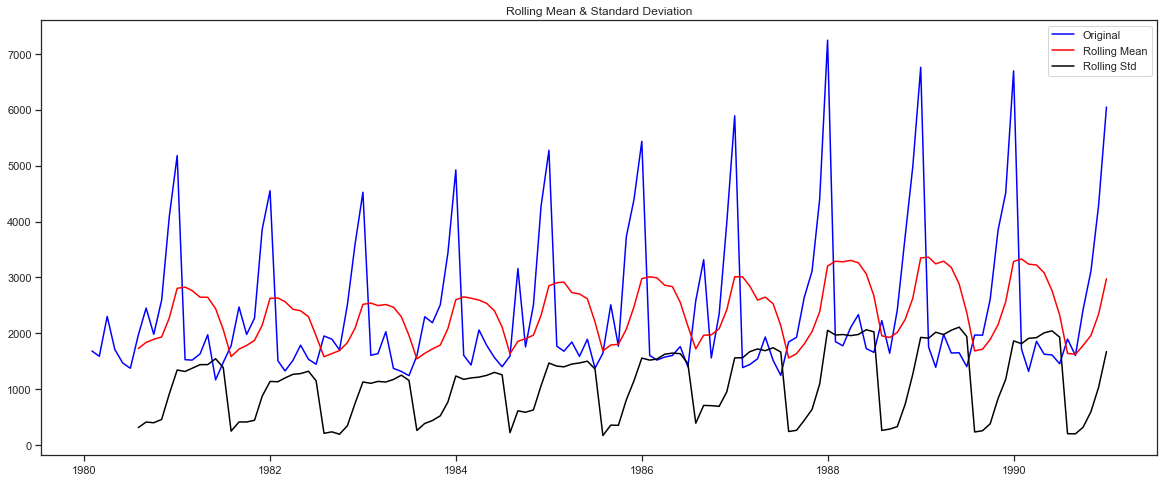

Results of Dickey-Fuller Test:
Test Statistic                  -1.208926
p-value                          0.669744
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64 



In [103]:
test_stationarity(train['Sparkling'])

We see that the series of train data is not stationary at  𝛼 = 0.05.

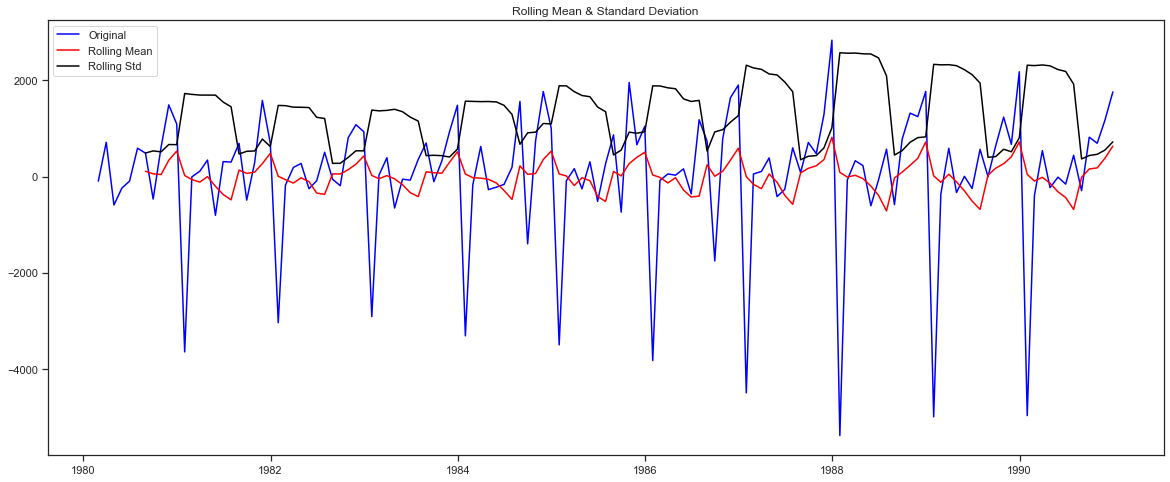

Results of Dickey-Fuller Test:
Test Statistic                -8.005007e+00
p-value                        2.280104e-12
#Lags Used                     1.100000e+01
Number of Observations Used    1.190000e+02
Critical Value (1%)           -3.486535e+00
Critical Value (5%)           -2.886151e+00
Critical Value (10%)          -2.579896e+00
dtype: float64 



In [104]:
test_stationarity(train['Sparkling'].diff().dropna())

We see that after taking a difference of order 1 the series have become stationary at  𝛼 = 0.05.

***Note: If the series is non-stationary, stationarize the Time Series by taking a difference of the Time Series. Then we can use this particular differenced series to train the ARIMA models. We do not need to worry about stationarity for the Test Data because we are not building any models on the Test Data, we are evaluating our models over there.***

In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 1980-01-31 to 1990-12-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sparkling  132 non-null    int64
dtypes: int64(1)
memory usage: 2.1 KB


#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#4B0082;">6. Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

### Build an Automated version of an ARIMA model for which the best parameters are selected in accordance with the lowest Akaike Information Criteria (AIC).

***Note: The data has some seasonality so ideally we should build a SARIMA model. But for confirmation purposes we are building an ARIMA model both by looking at the minimum AIC criterion and by looking at the ACF and the PACF plots.***

In [106]:
## The following loop helps us in getting a combination of different parameters of p and q in the range of 0 and 3
## We have kept the value of d as 1 as we need to take a difference of the series to make it stationary.

import itertools
p = q = range(0, 3)
d = range(1,2)
pdq = list(itertools.product(p, d, q))
print('Some parameter combinations for the Model...')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Some parameter combinations for the Model...
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)


In [107]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

Empty DataFrame
Columns: [param, AIC]
Index: []

In [108]:
for param in pdq:
    ARIMA_model = ARIMA(train['Sparkling'].values,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

ARIMA(0, 1, 0) - AIC:2269.582796371201
ARIMA(0, 1, 1) - AIC:2264.9064421638386


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(0, 1, 2) - AIC:2232.783097686022
ARIMA(1, 1, 0) - AIC:2268.5280607731743


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

ARIMA(1, 1, 1) - AIC:2235.0139453493066
ARIMA(1, 1, 2) - AIC:2233.5976471225426
ARIMA(2, 1, 0) - AIC:2262.03560049985
ARIMA(2, 1, 1) - AIC:2232.3604898876415


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA(2, 1, 2) - AIC:2210.6188287378523


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arim

In [109]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARIMA_AIC.sort_values(by='AIC',ascending=True)

param          AIC
8  (2, 1, 2)  2210.618829
7  (2, 1, 1)  2232.360490
2  (0, 1, 2)  2232.783098
5  (1, 1, 2)  2233.597647
4  (1, 1, 1)  2235.013945
6  (2, 1, 0)  2262.035600
1  (0, 1, 1)  2264.906442
3  (1, 1, 0)  2268.528061
0  (0, 1, 0)  2269.582796

In [110]:
auto_ARIMA = ARIMA(train['Sparkling'], order=(2,1,2),freq='M')

results_auto_ARIMA = auto_ARIMA.fit()

print(results_auto_ARIMA.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Sparkling   No. Observations:                  131
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1099.309
Method:                       css-mle   S.D. of innovations           1012.797
Date:                Sun, 28 Mar 2021   AIC                           2210.619
Time:                        01:00:24   BIC                           2227.870
Sample:                    02-29-1980   HQIC                          2217.629
                         - 12-31-1990                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.5855      0.517     10.808      0.000       4.573       6.598
ar.L1.D.Sparkling     1.2699      0.075     17.045      0.000       1.124       1.416
ar.L2.D.Sparkling    -0.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arim

### Predict on the Test Set using this model and evaluate the model.

In [111]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test))

In [112]:
rmse = mean_squared_error(test['Sparkling'],predicted_auto_ARIMA[0],squared=False)
print(rmse)

1374.5673434078706


In [113]:
resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['ARIMA(2,1,2)'])

resultsDf

RMSE
ARIMA(2,1,2)  1374.567343

### Build an Automated version of a SARIMA model for which the best parameters are selected in accordance with the lowest Akaike Information Criteria (AIC).

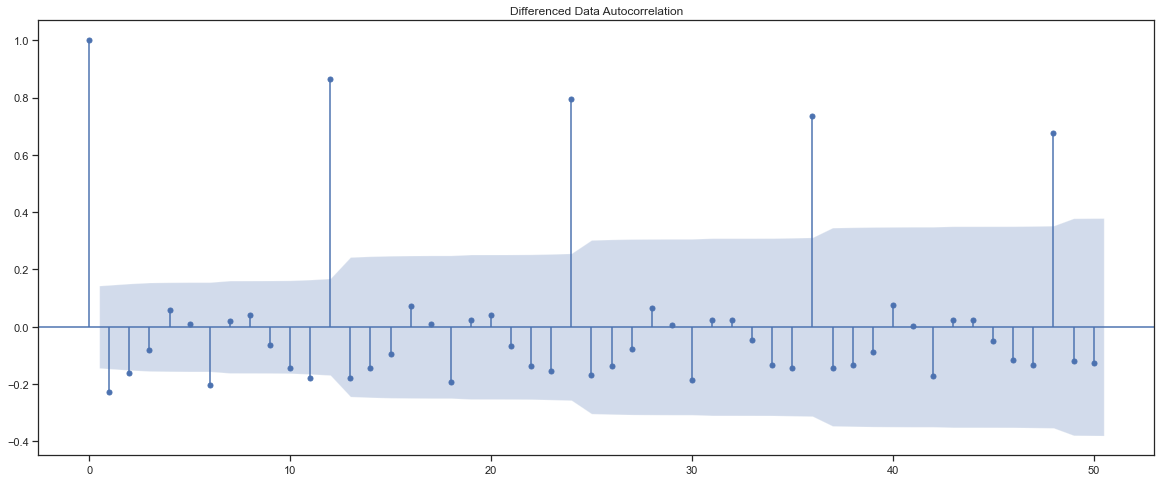

In [114]:
plot_acf(df['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plt.show()

We see that there can be a seasonality of 12. We will run our auto SARIMA models by setting seasonality 12.

#### Setting the seasonality as 12 for the first iteration of the auto SARIMA model.

In [115]:
import itertools
p = q = range(0, 3)
d= range(1,2)
D = range(1,2)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of some parameter combinations for Model...')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], model_pdq[i]))

Examples of some parameter combinations for Model...
Model: (0, 1, 1)(0, 1, 1, 12)
Model: (0, 1, 2)(0, 1, 2, 12)
Model: (1, 1, 0)(1, 1, 0, 12)
Model: (1, 1, 1)(1, 1, 1, 12)
Model: (1, 1, 2)(1, 1, 2, 12)
Model: (2, 1, 0)(2, 1, 0, 12)
Model: (2, 1, 1)(2, 1, 1, 12)
Model: (2, 1, 2)(2, 1, 2, 12)


In [116]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [117]:

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train['Sparkling'].values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:1822.9824851895298
SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:1626.8626334678327
SARIMA(0, 1, 0)x(0, 1, 2, 12) - AIC:1452.6773574257531
SARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:1646.3778167661442
SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:1628.3243908191555
SARIMA(0, 1, 0)x(1, 1, 2, 12) - AIC:1454.5289621306692
SARIMA(0, 1, 0)x(2, 1, 0, 12) - AIC:1466.6211360755017
SARIMA(0, 1, 0)x(2, 1, 1, 12) - AIC:1468.5000981866635
SARIMA(0, 1, 0)x(2, 1, 2, 12) - AIC:1455.9911553707875
SARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:1760.6565719828557
SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:1569.6639234230045
SARIMA(0, 1, 1)x(0, 1, 2, 12) - AIC:1399.1083846680306
SARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:1602.859481902385
SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:1570.8550259196152
SARIMA(0, 1, 1)x(1, 1, 2, 12) - AIC:1400.6709524137184
SARIMA(0, 1, 1)x(2, 1, 0, 12) - AIC:1428.2448811180316
SARIMA(0, 1, 1)x(2, 1, 1, 12) - AIC:1429.6168027963608
SARIMA(0, 1, 1)x(2, 1, 2, 12) - AIC:1402.6385888513264
SARIMA(0, 1

In [118]:
SARIMA_AIC.sort_values(by=['AIC']).head()

param       seasonal          AIC
47  (1, 1, 2)  (0, 1, 2, 12)  1382.347780
20  (0, 1, 2)  (0, 1, 2, 12)  1382.484254
50  (1, 1, 2)  (1, 1, 2, 12)  1384.137874
74  (2, 1, 2)  (0, 1, 2, 12)  1384.317618
23  (0, 1, 2)  (1, 1, 2, 12)  1384.398867

In [119]:

auto_SARIMA_12 = sm.tsa.statespace.SARIMAX(train['Sparkling'].values,
                                order=(1, 1, 2),
                                seasonal_order=(0,1,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto_SARIMA_12 = auto_SARIMA_12.fit(maxiter=1000)
print(results_auto_SARIMA_12.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -685.174
Date:                            Sun, 28 Mar 2021   AIC                           1382.348
Time:                                    01:01:11   BIC                           1397.479
Sample:                                         0   HQIC                          1388.455
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5507      0.287     -1.922      0.055      -1.112       0.011
ma.L1         -0.1612      0.235   

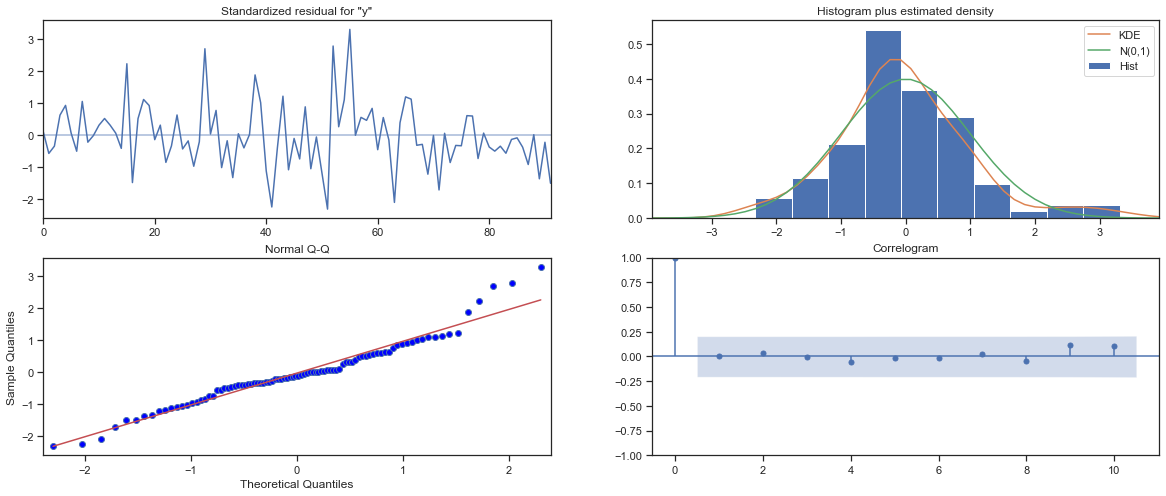

In [120]:
results_auto_SARIMA_12.plot_diagnostics()
plt.show()

From the model diagnostics plot, we can see that all the individual diagnostics plots almost follow the theoretical numbers and thus we cannot develop any pattern from these plots. 

#### Predict on the Test Set using this model and evaluate the model.

In [121]:
predicted_auto_SARIMA_12 = results_auto_SARIMA_12.get_forecast(steps=len(test))

In [122]:
predicted_auto_SARIMA_12.summary_frame(alpha=0.05).head()

y         mean     mean_se  mean_ci_lower  mean_ci_upper
0  1460.244604  412.922790     650.930806    2269.558401
1  1392.437127  429.721322     550.198812    2234.675441
2  1743.201658  430.065887     900.288009    2586.115307
3  1650.066893  433.930050     799.579624    2500.554162
4  1522.655985  434.242937     671.555469    2373.756501

In [123]:
rmse = mean_squared_error(test['Sparkling'],predicted_auto_SARIMA_12.predicted_mean,squared=False)
print(rmse)

382.57677139977585


In [124]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['SARIMA(1,1,2)(0,1,2,12)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf])

resultsDf

RMSE
ARIMA(2,1,2)             1374.567343
SARIMA(1,1,2)(0,1,2,12)   382.576771

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#4B0082;">7. Build ARIMA/SARIMA models based on the cut-off points of ACF and PACF on the training data and evaluate this model on the test data using RMSE.

***ARIMA Manual Cut-off points of ACF and PACF***

#### Build a version of the ARIMA model for which the best parameters are selected by looking at the ACF and the PACF plots.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


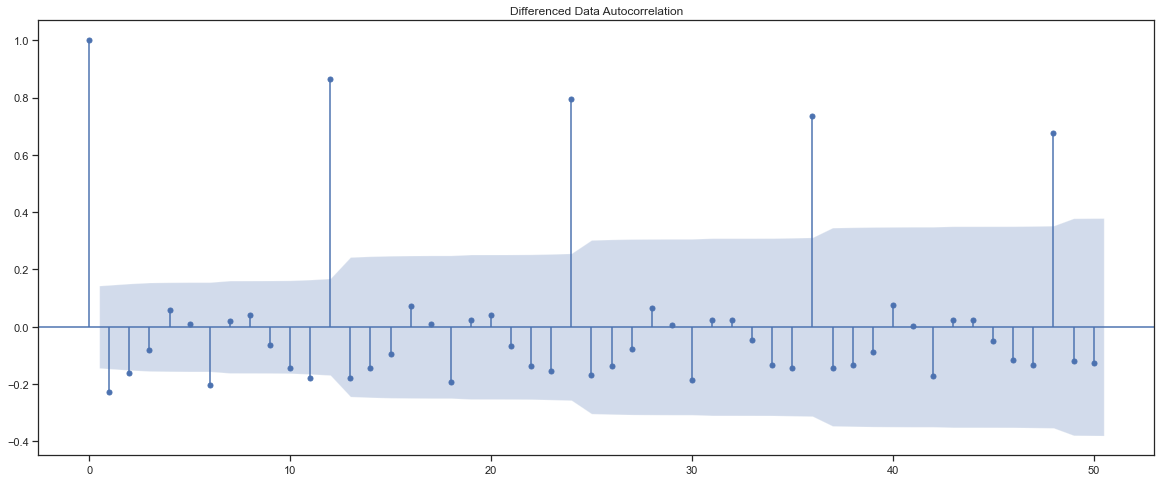

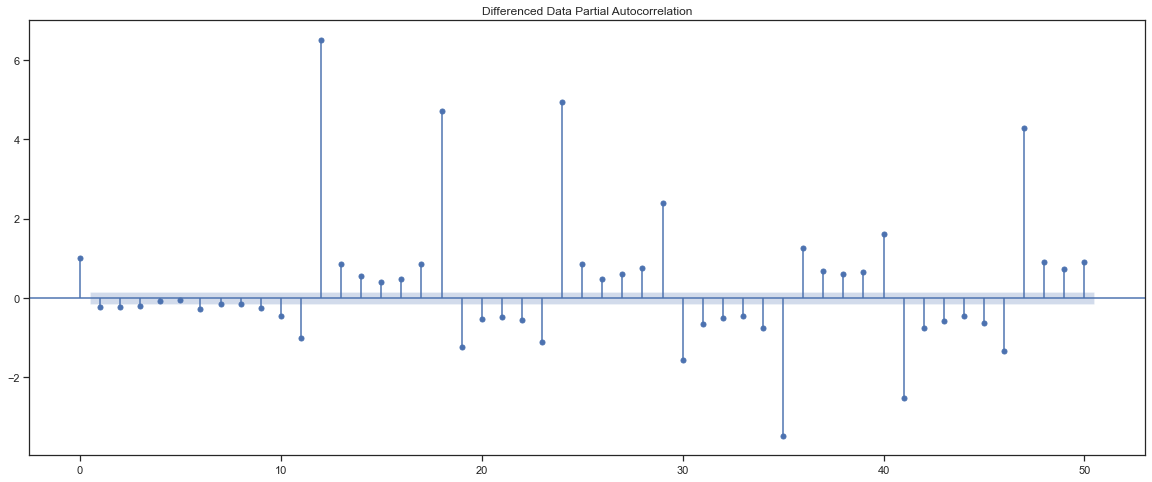

In [125]:
plot_acf(df['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plot_pacf(df['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Partial Autocorrelation')
plt.show()

Here, we have taken alpha=0.05.  

The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 3.  

The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 2.  

By looking at the above plots, we can say that both the PACF and ACF plot cuts-off at lag 3 & 2 respectively.

In [126]:
manual_ARIMA = ARIMA(train['Sparkling'].astype('float64'), order=(3,1,2),freq='M')

results_manual_ARIMA = manual_ARIMA.fit()

print(results_manual_ARIMA.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Sparkling   No. Observations:                  131
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1107.464
Method:                       css-mle   S.D. of innovations           1106.204
Date:                Sun, 28 Mar 2021   AIC                           2228.928
Time:                        01:01:13   BIC                           2249.054
Sample:                    02-29-1980   HQIC                          2237.106
                         - 12-31-1990                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.9887      3.645      1.643      0.100      -1.155      13.132
ar.L1.D.Sparkling    -0.4420   8.81e-06  -5.02e+04      0.000      -0.442      -0.442
ar.L2.D.Sparkling     0.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


#### Predict on the Test Set using this model and evaluate the model.

In [127]:
predicted_manual_ARIMA = results_manual_ARIMA.forecast(steps=len(test))

In [128]:
rmse = mean_squared_error(test['Sparkling'],predicted_manual_ARIMA[0],squared=False)
print(rmse)

1379.2085910476092


In [129]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['ARIMA(3,1,2)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf])

resultsDf

RMSE
ARIMA(2,1,2)             1374.567343
SARIMA(1,1,2)(0,1,2,12)   382.576771
ARIMA(3,1,2)             1379.208591

***SARIMA Manual Cut-off points of ACF and PACF***

#### Build a version of the SARIMA model for which the best parameters are selected by looking at the ACF and the PACF plots. - Seasonality at 12.

We shall look at the ACF and the PACF plots once more.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


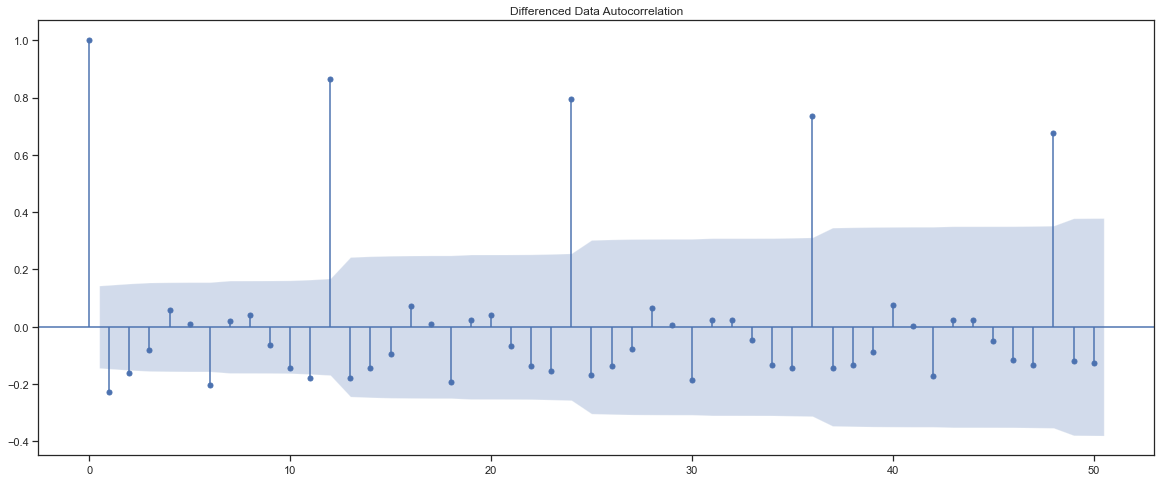

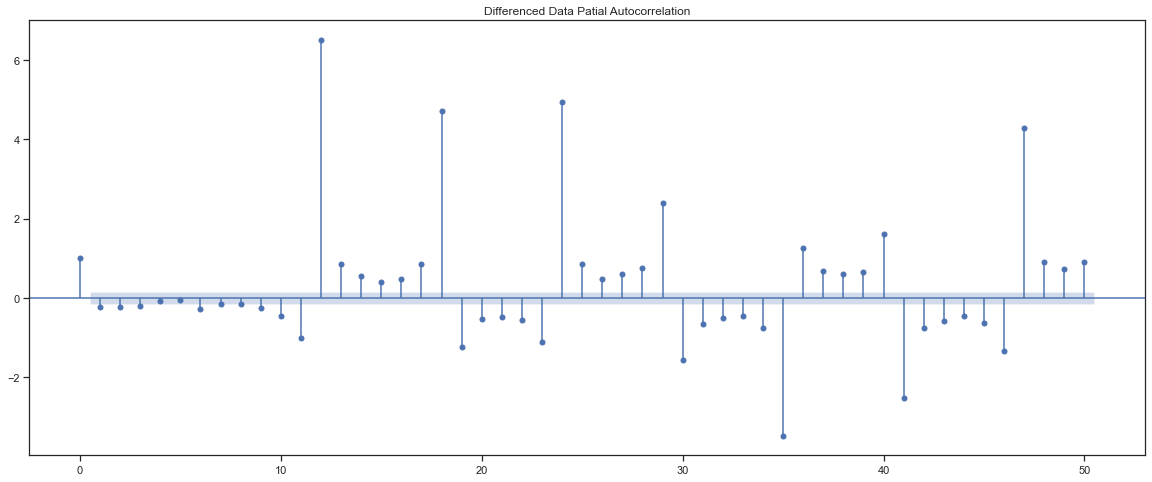

In [130]:
plot_acf(df['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation')
plot_pacf(df['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Patial Autocorrelation')
plt.show()

We see that our ACF plot at the seasonal interval (12) does not taper off. So, we go ahead and take a seasonal differencing of the original series. Before that let us look at the original series.

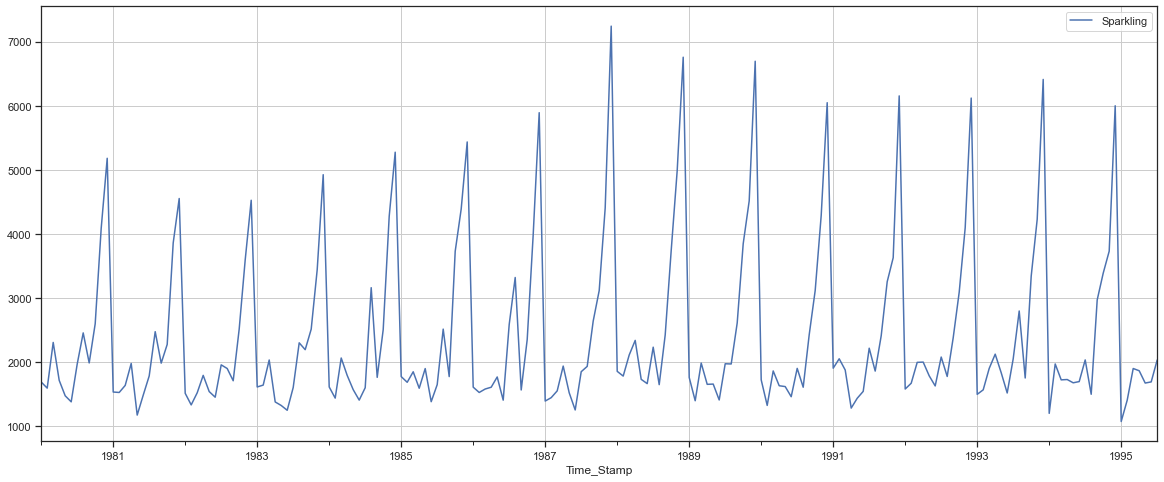

In [131]:
df.plot()
plt.grid();

We see that there is a trend and a seasonality. So, now we take a seasonal differencing and check the series.

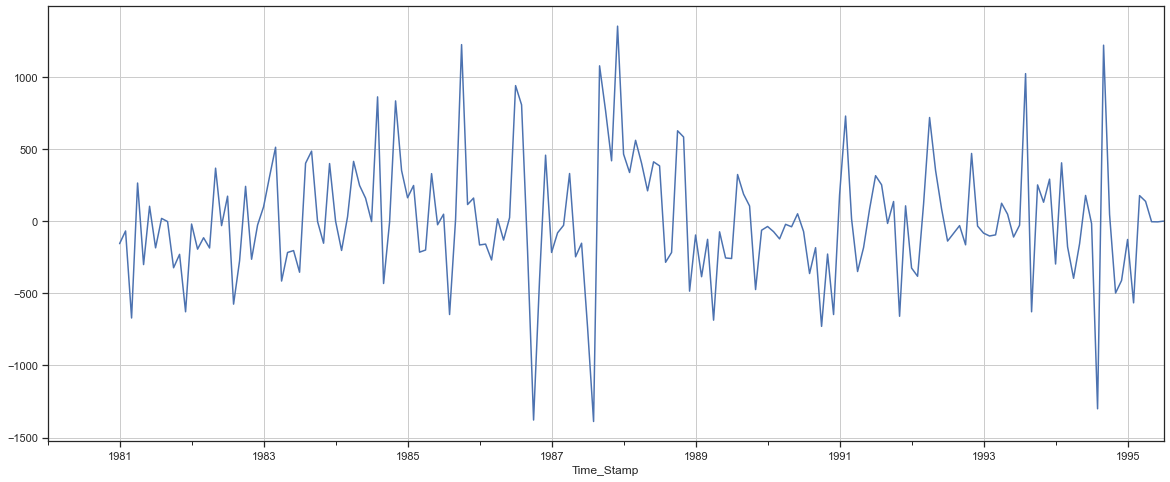

In [132]:
(df['Sparkling'].diff(12)).plot()
plt.grid();

Now we see that there is almost no trend present in the data. Seasonality is only present in the data.

Let us go ahead and check the stationarity of the above series before fitting the SARIMA model.

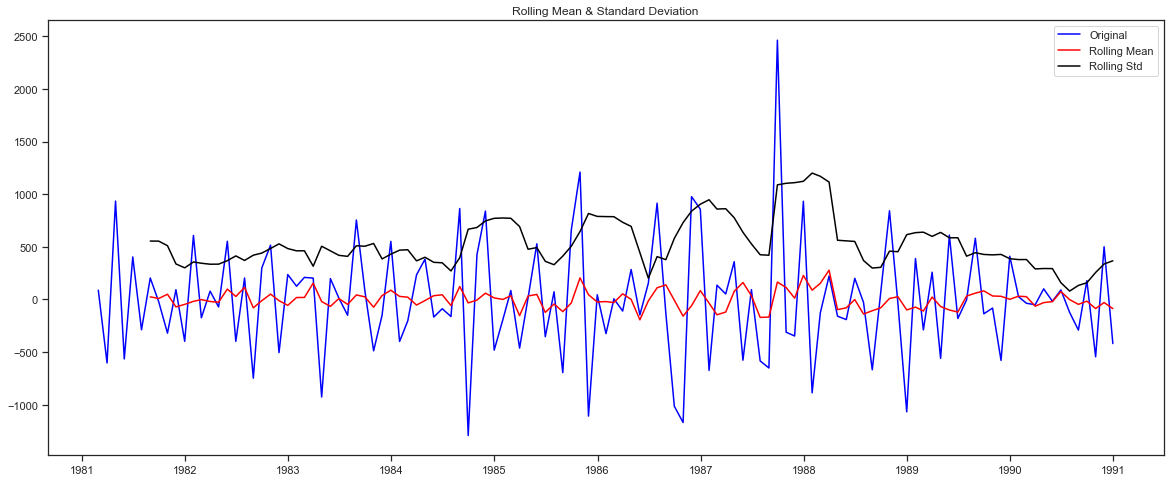

Results of Dickey-Fuller Test:
Test Statistic                  -3.342905
p-value                          0.013066
#Lags Used                      10.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64 



In [133]:
test_stationarity((train['Sparkling'].diff(12).dropna()).diff(1).dropna())

There's stationarity

Checking the ACF and the PACF plots for the new modified Time Series.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


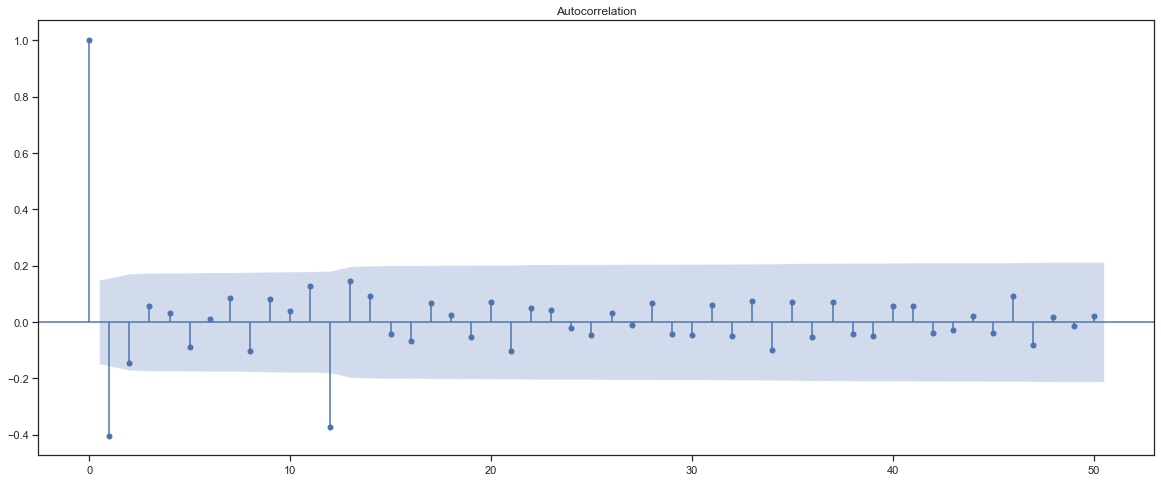

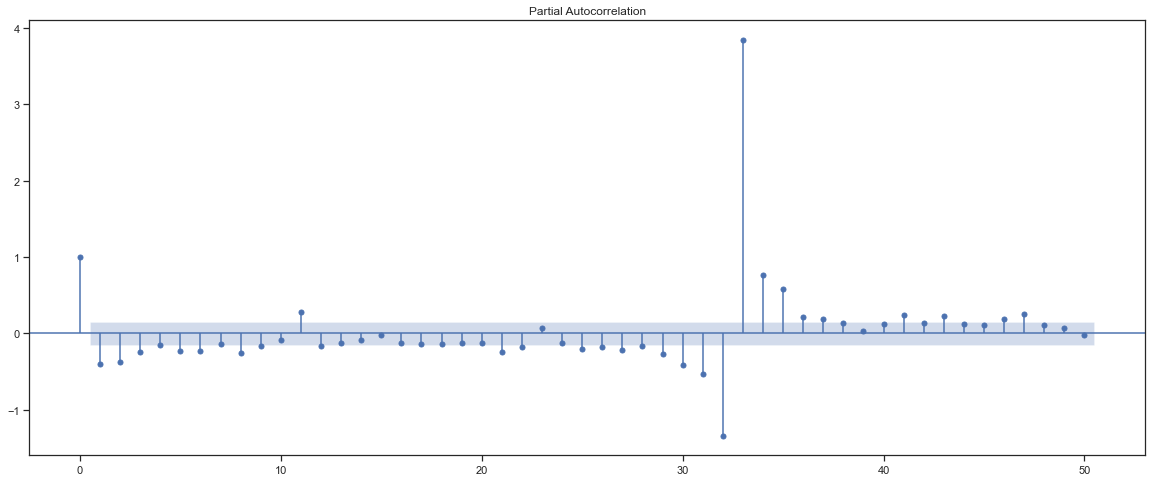

In [134]:
plot_acf((df['Sparkling'].diff(12).dropna()).diff(1).dropna(),lags=50)
plot_pacf((df['Sparkling'].diff(12).dropna()).diff(1).dropna(),lags=50);

Here, we have taken alpha=0.05.

We are going to take the seasonal period as 12.
We will keep the p(2) and q(2) parameters same as the ARIMA model.

* The Auto-Regressive parameter in an SARIMA model is 'P' which comes from the significant lag after which the PACF plot cuts-off to 3. 
* The Moving-Average parameter in an SARIMA model is 'q' which comes from the significant lag after which the ACF plot cuts-off to 1.
Remember to check the ACF and the PACF plots only at multiples of 12 (since 12 is the seasonal period).

By looking at the plots we see that the ACF and the PACF do not directly cut-off to 0.

This is a common problem while building models by looking at the ACF and the PACF plots. But we are able to explain the model. 

In [135]:
manual_SARIMA_12 = sm.tsa.statespace.SARIMAX(train['Sparkling'].values,
                                order=(2,1,2),
                                seasonal_order=(3,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_manual_SARIMA_12 = manual_SARIMA_12.fit(maxiter=1000)
print(results_manual_SARIMA_12.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(2, 1, 2)x(3, 1, [1], 12)   Log Likelihood                -606.105
Date:                              Sun, 28 Mar 2021   AIC                           1230.209
Time:                                      01:01:18   BIC                           1251.759
Sample:                                           0   HQIC                          1238.856
                                              - 132                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5701      0.339     -1.682      0.092      -1.234       0.094
ar.L2          0.03

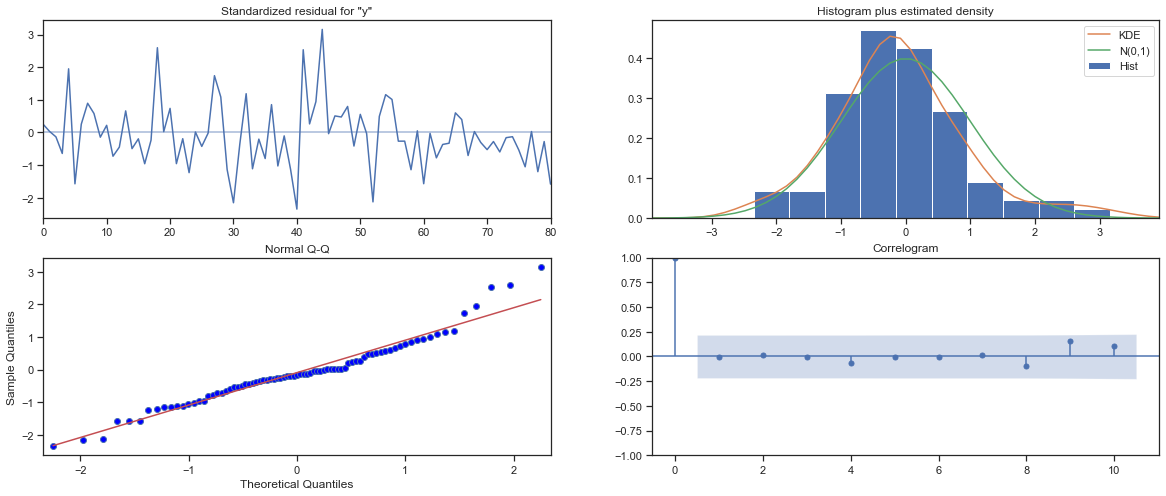

In [136]:
results_manual_SARIMA_12.plot_diagnostics()
plt.show()

The model diagnostics plot looks okay.

#### Predict on the Test Set using this model and evaluate the model.

In [137]:
predicted_manual_SARIMA_12 = results_manual_SARIMA_12.get_forecast(steps=len(test))

In [138]:
predicted_manual_SARIMA_12.summary_frame(alpha=0.05).head()

y         mean     mean_se  mean_ci_lower  mean_ci_upper
0  1488.215947  429.370620     646.664996    2329.766898
1  1439.292664  445.053958     567.002935    2311.582392
2  1788.428320  445.381431     915.496755    2661.359885
3  1739.956659  448.066143     861.763156    2618.150163
4  1561.594259  448.117758     683.299593    2439.888925

In [139]:
rmse = mean_squared_error(test['Sparkling'],predicted_manual_SARIMA_12.predicted_mean,squared=False)
print(rmse)

337.35863433443006


In [140]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['SARIMA(2,1,2)(3,1,1,12)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf])

resultsDf

RMSE
ARIMA(2,1,2)             1374.567343
SARIMA(1,1,2)(0,1,2,12)   382.576771
ARIMA(3,1,2)             1379.208591
SARIMA(2,1,2)(3,1,1,12)   337.358634

At this juncture, the model building exercise ends. 

Now, we shall take our best model among ARIMA/SARIMA and forecast 12 months into the future with appropriate confidence intervals to see how the predictions look. We have to build our model on the full data for this.



#### Building the most optimum model on the Full Data - SARIMA(2,1,2)(3,1,1,12)	with lowest RMSE value of 350.816988

In [141]:
full_data_model = sm.tsa.statespace.SARIMAX(df['Sparkling'],
                                order=(2,1,2),
                                seasonal_order=(3,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_full_data_model = full_data_model.fit(maxiter=1000)
print(results_full_data_model.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                            Sparkling   No. Observations:                  187
Model:             SARIMAX(2, 1, 2)x(3, 1, [1], 12)   Log Likelihood               -1006.928
Date:                              Sun, 28 Mar 2021   AIC                           2031.855
Time:                                      01:01:26   BIC                           2058.069
Sample:                                  01-31-1980   HQIC                          2042.508
                                       - 07-31-1995                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7442      0.252     -2.949      0.003      -1.239      -0.250
ar.L2          0.01

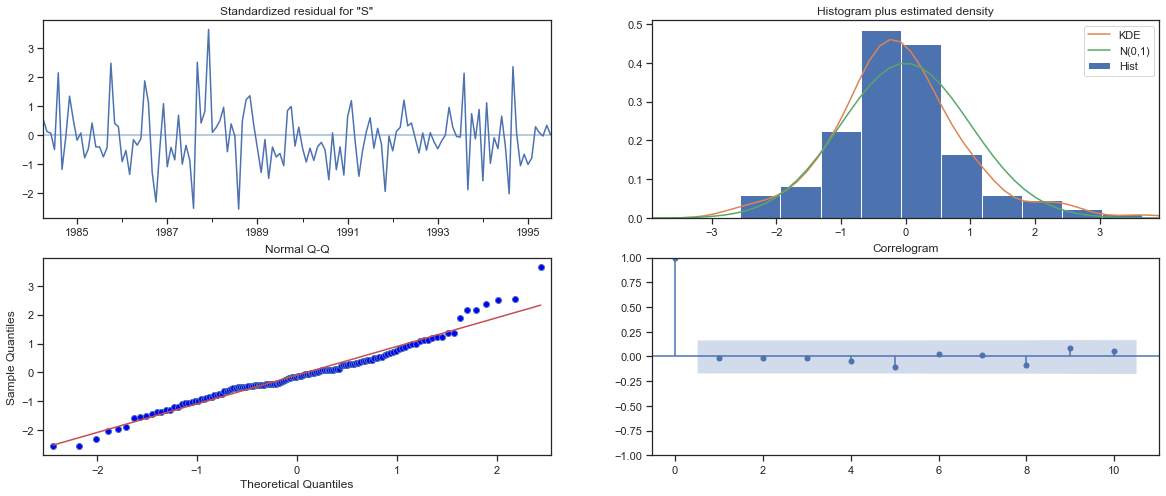

In [142]:
results_full_data_model.plot_diagnostics();

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#4B0082;">8. Build a table (create a data frame) with all the models built along with their corresponding parameters and the respective RMSE values on the test data.

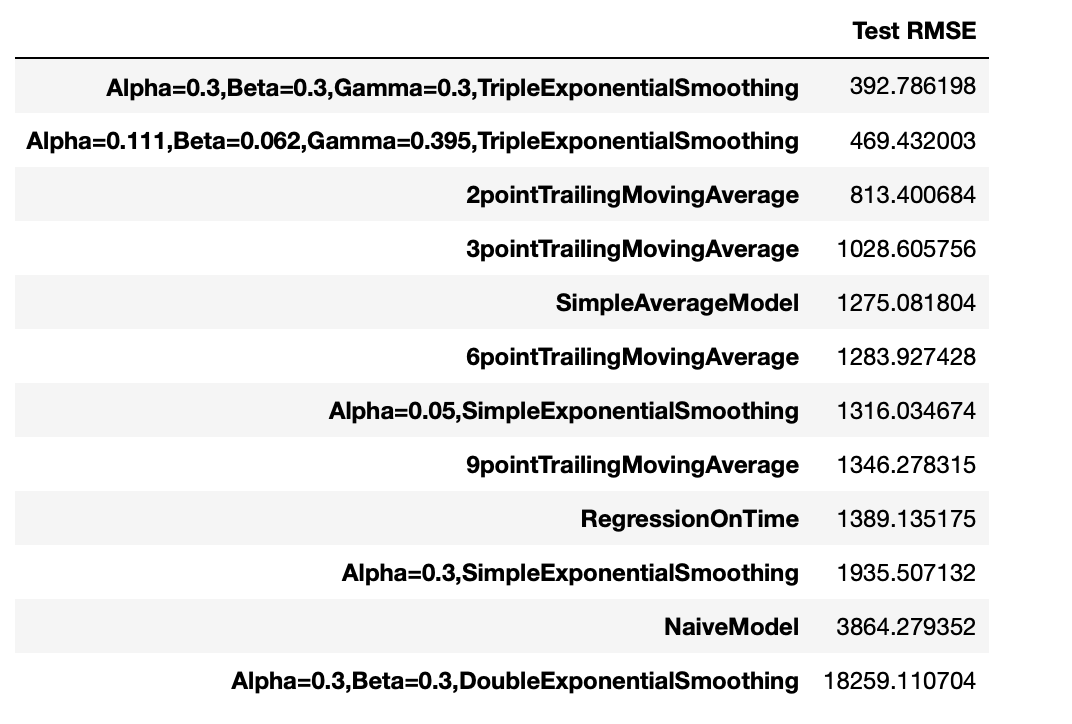

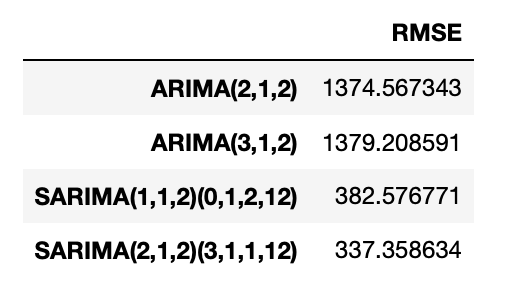

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#4B0082;">9. Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.

### Evaluate the model SARIMA(2,1,2)(3,1,1,12) on the whole and predict 12 months into the future (till the end of next year).

In [143]:
predicted_manual_SARIMA_12_full_data = results_full_data_model.get_forecast(steps=12)

In [144]:
rmse = mean_squared_error(df['Sparkling'],results_full_data_model.fittedvalues,squared=False)
print('RMSE of the Full Model',rmse)

RMSE of the Full Model 581.8390430519648


In [145]:
pred_full_manual_SARIMA_date = predicted_manual_SARIMA_12_full_data.summary_frame(alpha=0.05).set_index(pd.date_range(start='1995-08-31',end='1996-07-31', freq='M'))

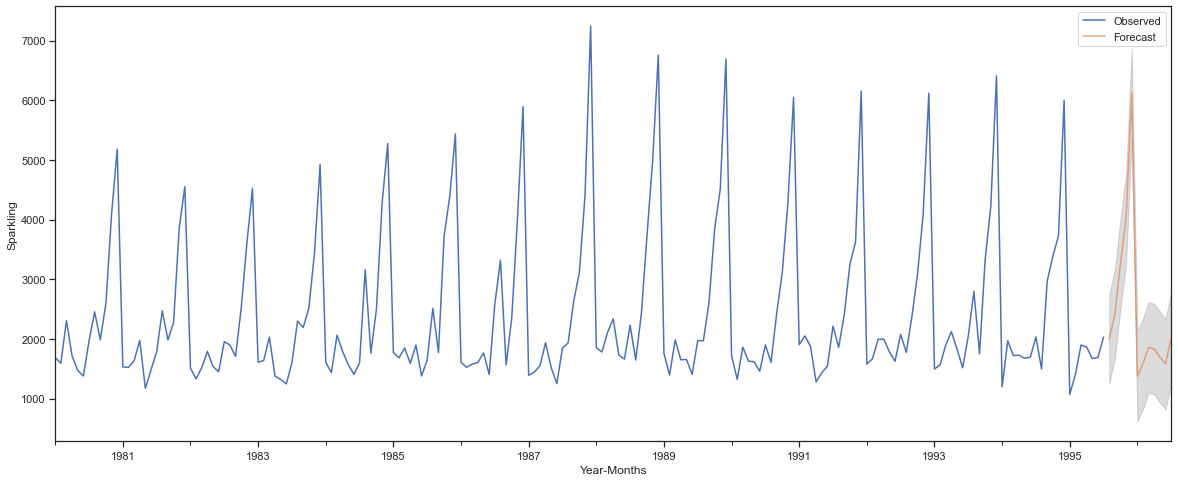

In [146]:
# plot the forecast along with the confidence band

axis = df['Sparkling'].plot(label='Observed')
pred_full_manual_SARIMA_date['mean'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(pred_full_manual_SARIMA_date.index, pred_full_manual_SARIMA_date['mean_ci_lower'], 
                  pred_full_manual_SARIMA_date['mean_ci_upper'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Sparkling')
plt.legend(loc='best')
plt.show()

In [147]:
predicted_manual_SARIMA_12_full_data.summary_frame(alpha=0.05).head(12)

Sparkling          mean     mean_se  mean_ci_lower  mean_ci_upper
1995-08-31  1996.043747  379.474478    1252.287436    2739.800058
1995-09-30  2409.434151  384.121212    1656.570410    3162.297893
1995-10-31  3259.472036  384.124766    2506.601329    4012.342744
1995-11-30  4031.081390  386.061282    3274.415182    4787.747598
1995-12-31  6118.888690  386.107075    5362.132728    6875.644652
1996-01-31  1372.652565  387.025601     614.096325    2131.208804
1996-02-29  1584.424640  387.185606     825.554798    2343.294483
1996-03-31  1856.693786  387.818349    1096.583789    2616.803784
1996-04-30  1828.970220  388.121890    1068.265295    2589.675146
1996-05-31  1693.607036  388.751929     931.667256    2455.546816
1996-06-30  1578.359059  389.147713     815.643556    2341.074562
1996-07-31  2022.830861  389.737509    1258.959380    2786.702341

#### <span style="font-family: Arial; font-weight:bold;font-size:1.3em;color:#4B0082;">10. Comment on the model thus built and report your findings and suggest the measures that the company should be taking for future sales.


Findings:

1. Has 187 records of ‘Sparkling Wine Sales’ and 2 columns, 
		Year-Month - indicating time period 		Sparkling - Sales data.
	The data had to reset as Time-Stamp with Year Month getting converted to index in a
        	DatetimeIndex.
2. The data type of Sparkling is of ‘int64’ type.
3. The dataset is checked and has ‘No’ null/missing values.
4. The frequecy of the Time-Stamp is ‘M’ i.e. Monthly.
5. The Period starts from January 1980 and ends at July 1995.
6. The Highest Sales has happened in December 1987 - 7242
7. The lowest Sales has happened in January 1995 - 1070
8. The sales has a fluctuating trend where it increased from 1983-1989 then there is a drop in Sales.
     1993 tried to catch up with the peak trend of 1983-1989 but then dropped.
     Note: 1995 has only 7 months sales figure and not for entire 12 months of the year.
     When we plot the Monthly Sales figures of 'Sparkling Wine Sales' across various years, there is a
     good seasonal trend emerging where the Sales peaks in December and has an increasing trend
     from August-December. Then the sales abruptly drops in January. This trend continues with minor
     variations between January-July.
9. From the above Cumulative Distribution Function plot, it is seen that around 60-65% of Sales are
    around 2000 and below.
10. From the Simple Methods and Exponential somm=e=oothing methods, the following are the models
     which had bettered with lowest RMSE values on Test data:
	Alpha=0.3,Beta=0.3,Gamma=0.3,TripleExponentialSmoothing              -  392.78619.
	Alpha=0.111,Beta=0.062,Gamma=0.395,TripleExponentialSmoothing  -  469.432003
11. Since there was a 12 months seasonality, among the ARIMA/SARIMA models using both Auto as
      well as Manual ACF/PACF cut-off values, the Manual Sarima (2,1,2) (3,1,1,12)  performed better with
      lowest RMSE values of 337.358634.  The same was built on the whole data with a full model as got
      the RMSE value of 581.83904
12. The forecasting is done for 12 months (Aug 1995 to Jul 1996) with confidence interval of 95%
      (Mean is the forecast value with mean_se is the standard error. Band is lower to upper)

Recommendations:

1. The sales is steadied around the same seasonal pattern of Novemeber and Decemebr giving
      highest sales of the year.
2. To boost up sales during non-seasonal months of Jan-Aug, special schemes and promotional
      campaigns can be run. Also expansion into newer markets of the other hemispheretoo can be
      considered to boost up sales as the season is different.


--------------------------------------------------------- End of Report ----------------------------------------------------------------------------